In [1]:
import numpy as np
import pymc as pm
import arviz as az
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import pytensor.tensor as tt

from scipy.io.wavfile import read
from numba import njit

# Import data

In [2]:
folder_data = "audiovisual_data/data/"

In [3]:
# V only trials
data_no = pd.read_csv(
        folder_data + 'absent_noise_data.csv',
        header=0,
        names=["Rat", "Frequency", "Noise_Frequency", "-", "Response", "RT"])
data_no=data_no.drop(["-"],axis=1)
data_no["Noise_type"] = 0
data_no["Noise_Frequency"] = 0.00001

# AM sound trials
data_av = pd.read_csv(
        folder_data + 'AV_data.csv',
        header=0,
        names=["Rat", "Frequency", "Noise_Frequency", "-", "Response", "RT"])
data_av=data_av.drop(["-"],axis=1)
data_av["Noise_type"] = 1

# Fixed amplitude sound trials
data_steady = pd.read_csv(
        folder_data + 'steady_noise_data.csv',
        header=0,
        names=["Rat", "Frequency", "Noise_Frequency", "-", "Response", "RT"])
data_steady=data_steady.drop(["-"],axis=1)
data_steady["Noise_type"] = 2
data_steady["Noise_Frequency"] = 1000
data_steady = data_steady[~(data_steady["Frequency"]==0)] # Remove the trials with TF = 0 (no gratings presented)

# Concatenating all the data
data = pd.concat([data_av,data_no,data_steady])
data["Noise_5_types"] = 0
data["Freq_idx"] = data['Frequency'].rank(method='dense', ascending=True).astype(int)-1
data["Noise_idx"] = data['Noise_Frequency'].rank(method='dense', ascending=True).astype(int)-1
data.sort_values(by=["Noise_idx","Frequency","Rat"],ascending=True, ignore_index=True,inplace=True)
data

# Dividiing the data in 5 types, grouping AM sounds with Freq in [1.32,4]
j=0
for i in data["Noise_idx"].unique():
    data.loc[data["Noise_idx"]==i,"Noise_5_types"] = j
    if (i<3 or i==9): j+=1

data

,Rat,Frequency,Noise_Frequency,Response,RT,Noise_type,Noise_5_types,Freq_idx,Noise_idx
0,1,0.25,0.00001,0,0.529176,0,0,1,0
1,1,0.25,0.00001,0,0.530772,0,0,1,0
2,1,0.25,0.00001,0,1.380059,0,0,1,0
3,1,0.25,0.00001,0,0.550375,0,0,1,0
4,1,0.25,0.00001,0,0.942940,0,0,1,0
...,...,...,...,...,...,...,...,...,...
77719,10,4.00,1000.00000,1,0.606285,2,4,9,10
77720,10,4.00,1000.00000,1,0.678122,2,4,9,10
77721,10,4.00,1000.00000,1,0.828017,2,4,9,10
77722,10,4.00,1000.00000,1,0.680661,2,4,9,10


# Sound data and Calibration

In [4]:
folder_white_noise = "audiovisual_data/White_noise_sounds/"

In [5]:
# Copmutation of f through calibraton-white-noise audio

audio_signal = read(folder_white_noise + "1_gaussian_scaled_1X.wav") # Calibration white noise
audio_signal = np.array(audio_signal[1],dtype=float)
audio_signal /= 32767 # Normalization of WAV file values

sigma_audio = np.std(audio_signal)

Intensity_measured_silence = 32 # dB
Intensity_measured_audio = 72 # dB

p_silence = np.sqrt(10**(Intensity_measured_silence/10)) # pressure over p_0
p_audio = np.sqrt(10**(Intensity_measured_audio/10) - p_silence**2)

f = p_audio/sigma_audio

f * 0.000020 # f in Pascal

0.3909075316167258

In [6]:
@njit
def decibel_intensity(signal, chunks_len=100):
    chunked = np.array_split(signal,  max(len(signal),chunks_len)//chunks_len)
    dec_pow = []
    for chunk in chunked:
        dec_pow.append(10*np.log10(f**2 * np.mean(np.absolute(chunk)**2) + p_silence**2))
    return np.array(dec_pow)

@njit 
def avg_decibel_intensity(freq, T, chunks_len = 100):
    n_freq = np.where(freqs == freq)[0][0]
    i_time = int(T * nu_WN)
    signal = sequences[n_freq][:i_time]
    return np.mean(decibel_intensity(signal, chunks_len))

MoRsT = 0.3

### Import Sound Sequences

In [7]:
freqs = data["Noise_Frequency"].unique()

nu_WN = 44100
times_WN = np.arange(2 * nu_WN) / ( nu_WN ) 

sequences = np.zeros((len(freqs), nu_WN * 2))

for i_v in range(len(freqs)):
    v = freqs[i_v]
    if v < 0.001:
        continue   
    if v>100:        
        a = read(folder_white_noise + "White_Noise.wav")
        imported_true_signal = np.array(a[1],dtype=float)[:,0]
        imported_true_signal /= 32767
        imported_true_signal_elongated = np.zeros(2*nu_WN)
        imported_true_signal_elongated[0:len(imported_true_signal)-4000] = imported_true_signal[0:-4000]
        imported_true_signal_elongated[-4000:] = imported_true_signal[-4000:]
        imported_true_signal_elongated[len(imported_true_signal)-4000:-4000] = np.random.choice(imported_true_signal, len(imported_true_signal_elongated) - len(imported_true_signal))
        signal = imported_true_signal_elongated    
    else:
        a = read(folder_white_noise + "noise_" + str(int(v*100)) + ".wav")
        signal = np.array(a[1],dtype=float)
        signal/= 32767
    sequences[i_v] = signal
    
sequences_parced = sequences[:,0::3]

# Bayesian hierarchical models

In [8]:
k0 = 2.12

def Φ(x):
    return (1+tt.erf(x/np.sqrt(2)))/2

coords = {
    "Noise_idx": data["Noise_idx"].unique(),
    "Noise_5_types": data["Noise_5_types"].unique(),
    "Rat": data["Rat"].unique(),
    "Frequency": data["Frequency"].unique(),
}

# Dictionary with all the models that will be compared
models = {}

#### 5γ 1σ

In [9]:
with pm.Model(coords=coords) as models['5γ_1σ']:

    sigma_loc = pm.Exponential('σ_μ', lam=1/3)
    sigma_scale = pm.Exponential('σ_σ', lam=1/3)
    
    gamma_loc = pm.Normal('γ_μ', mu=0, sigma=3, dims="Noise_5_types").dimshuffle(0,'x')
    gamma_scale = pm.Exponential('γ_σ', lam=1/3, dims="Noise_5_types").dimshuffle(0,'x')

    ϵ = pm.Dirichlet("ϵ",[1,1,1], size=(len(data["Rat"].unique())), dims="Rat").T
    
    σ = pm.Gamma('σ', mu=sigma_loc, sigma=sigma_scale, dims="Rat")
    γ = pm.Normal('γ', mu=gamma_loc, sigma=gamma_scale, dims=("Noise_5_types","Rat"))

    gamma = tt.concatenate([γ[i][data.query('Noise_5_types=='+str(i))["Rat"]-1] for i in range(len(data["Noise_5_types"].unique()))])

    rescaled = gamma * data["Frequency"]
    p = Φ((rescaled-k0)/σ[data["Rat"]-1])
    p = ϵ[0][data["Rat"]-1] + ϵ[1][data["Rat"]-1] * p

    Choice = pm.Bernoulli("Choice", p,observed=data["Response"])

    # Variables used for analysis
    p = pm.Deterministic("p", ϵ[0][data["Rat"]-1] + ϵ[1][data["Rat"]-1] * p)

#### 5γ 5σ

In [10]:
with pm.Model(coords=coords) as models['5γ_5σ']:

    sigma_loc = pm.Normal('σ_μ', mu=0, sigma=3, dims="Noise_5_types").dimshuffle(0,'x')
    sigma_scale = pm.Exponential('σ_σ', lam=1/3, dims="Noise_5_types").dimshuffle(0,'x')
    
    gamma_loc = pm.Normal('γ_μ', mu=0, sigma=3, dims="Noise_5_types").dimshuffle(0,'x')
    gamma_scale = pm.Exponential('γ_σ', lam=1/3, dims="Noise_5_types").dimshuffle(0,'x')

    ϵ = pm.Dirichlet("ϵ",[1,1,1], size=(len(data["Rat"].unique())), dims="Rat").T
    
    # Non-centered parameterization for sigma and gamma
    sigma_offset = pm.Normal('σ_offset', mu=0, sigma=1, dims=("Noise_5_types","Rat"))
    gamma_offset = pm.Normal('γ_offset', mu=0, sigma=1, dims=("Noise_5_types","Rat"))

    σ = pm.Deterministic('σ', tt.exp(sigma_loc + sigma_scale * sigma_offset), dims=("Noise_5_types","Rat"))
    γ = pm.Deterministic('γ', gamma_loc + gamma_scale * gamma_offset, dims=("Noise_5_types","Rat"))

    gamma = tt.concatenate([γ[i][data.query('Noise_5_types=='+str(i))["Rat"]-1] for i in range(len(data["Noise_5_types"].unique()))])
    sigma = tt.concatenate([σ[i][data.query('Noise_5_types=='+str(i))["Rat"]-1] for i in range(len(data["Noise_5_types"].unique()))])

    rescaled = gamma * data["Frequency"]
    p = Φ((rescaled-k0)/sigma)
    p = ϵ[0][data["Rat"]-1] + ϵ[1][data["Rat"]-1] * p

    Choice = pm.Bernoulli("Choice", p,observed=data["Response"])

#### 1γ 5σ

In [11]:
with pm.Model(coords=coords) as models['1γ_5σ']:

    sigma_loc = pm.Normal('σ_μ', mu=0, sigma=3, dims="Noise_5_types").dimshuffle(0,'x')
    sigma_scale = pm.Exponential('σ_σ', lam=1/3, dims="Noise_5_types").dimshuffle(0,'x')
    
    gamma_loc = pm.Normal('γ_μ', mu=0, sigma=3)
    gamma_scale = pm.Exponential('γ_σ', lam=1/3)

    ϵ = pm.Dirichlet("ϵ",[1,1,1], size=(len(data["Rat"].unique())), dims="Rat").T
    
    sigma_offset = pm.Normal('σ_offset', mu=0, sigma=1, dims=("Noise_5_types","Rat"))

    σ = pm.Deterministic('σ', tt.exp(sigma_loc + sigma_scale * sigma_offset), dims=("Noise_5_types","Rat"))
    γ = pm.Normal('γ', mu=gamma_loc, sigma=gamma_scale, dims="Rat")

    sigma = tt.concatenate([σ[i][data.query('Noise_5_types=='+str(i))["Rat"]-1] for i in range(len(data["Noise_5_types"].unique()))])

    rescaled = γ[data["Rat"]-1] * data["Frequency"]
    p = Φ((rescaled-k0)/sigma)
    p = ϵ[0][data["Rat"]-1] + ϵ[1][data["Rat"]-1] * p

    Choice = pm.Bernoulli("Choice", p,observed=data["Response"])

#### 5γ 1σ 1λ

In [12]:
with pm.Model(coords=coords) as models['5γ_1σ_λ']:

    sigma_loc = pm.Normal('σ_μ', mu=0, sigma=3)
    sigma_scale = pm.Exponential('σ_σ', lam=1/3)

    gamma_loc = pm.Normal('γ_μ', mu=0, sigma=3, dims="Noise_5_types").dimshuffle(0,'x')
    gamma_scale = pm.Exponential('γ_σ', lam=1/3, dims="Noise_5_types").dimshuffle(0,'x')

    lambda_loc = pm.Normal('λ_μ', mu=0, sigma=1)
    lambda_scale = pm.Exponential('λ_σ', lam=15)

    ϵ = pm.Dirichlet("ϵ",[1,1,1], size=(10), dims="Rat").T

    # Non-centered parameterization for sigma, gamma and lambda
    sigma_raw = pm.Normal('σ_raw', mu=0, sigma=1, dims="Rat")
    σ = pm.Deterministic('σ', tt.exp(sigma_loc + sigma_scale * sigma_raw), dims="Rat")

    γ_raw = pm.Normal('γ_raw', mu=0, sigma=1, dims=("Noise_5_types","Rat"))
    γ = pm.Deterministic('γ', gamma_loc + gamma_scale * γ_raw)

    λ_raw = pm.Normal('λ_raw', mu=0, sigma=1, dims="Rat")
    λ = pm.Deterministic('λ', lambda_loc + lambda_scale * λ_raw)

    gamma = tt.concatenate([γ[i][data.query('Noise_5_types=='+str(i))["Rat"]-1] for i in range(len(data["Noise_5_types"].unique()))])

    data_lamb = λ[data["Rat"]-1] + data["Frequency"]
    k0_lamb = k0 + λ[data["Rat"]-1]

    rescaled = gamma * data_lamb
    p = Φ((rescaled-k0_lamb)/σ[data["Rat"]-1])
    p = ϵ[0][data["Rat"]-1] + ϵ[1][data["Rat"]-1] * p

    Choice = pm.Bernoulli("Choice", p, observed=data["Response"])

#### 11γ 1σ

In [13]:
with pm.Model(coords=coords) as models['11γ_1σ']:

    # population-level parameters
    sigma_loc = pm.Exponential('σ_μ', lam=1/3)
    sigma_scale = pm.Exponential('σ_σ', lam=1/3)
    
    gamma_loc = pm.Normal('γ_μ', mu=0, sigma=3, dims="Noise_idx").dimshuffle(0,'x')
    gamma_scale = pm.Exponential('γ_σ', lam=1/3, dims="Noise_idx").dimshuffle(0,'x')

    ϵ = pm.Dirichlet("ϵ",[1,1,1], size=(10), dims="Rat").T
    
    σ = pm.Gamma('σ', mu=sigma_loc, sigma=sigma_scale, dims="Rat")
    γ = pm.Normal('γ', mu=gamma_loc, sigma=gamma_scale, dims=("Noise_idx","Rat"))

    gamma = tt.concatenate([γ[i][data.query('Noise_idx=='+str(i))["Rat"]-1] for i in range(len(data["Noise_idx"].unique()))])

    rescaled = gamma * data["Frequency"]
    p = Φ((rescaled-k0)/σ[data["Rat"]-1])
    p = ϵ[0][data["Rat"]-1] + ϵ[1][data["Rat"]-1] * p

    Choice = pm.Bernoulli("Choice", p,observed=data["Response"])

#### 1γ 1σ

In [14]:
with pm.Model(coords=coords) as models['1γ_1σ']:

    sigma_loc = pm.Exponential('σ_μ', lam=1/3)
    sigma_scale = pm.Exponential('σ_σ', lam=1/3)
    
    gamma_loc = pm.Normal('γ_μ', mu=0, sigma=3)
    gamma_scale = pm.Exponential('γ_σ', lam=1/3)

    ϵ = pm.Dirichlet("ϵ",[1,1,1], size=(len(data["Rat"].unique())), dims="Rat").T
    
    σ = pm.Gamma('σ', mu=sigma_loc, sigma=sigma_scale, dims="Rat")
    γ = pm.Normal('γ', mu=gamma_loc, sigma=gamma_scale, dims="Rat")

    rescaled = γ[data["Rat"]-1]*data["Frequency"]
    p = Φ((rescaled-k0)/σ[data["Rat"]-1])
    p = ϵ[0][data["Rat"]-1] + ϵ[1][data["Rat"]-1] * p

    Choice = pm.Bernoulli("Choice", p,observed=data["Response"])

### Linear

In [15]:
rat_dBintensity_per_freq = np.zeros((len(data["Rat"].unique()), len(freqs)))

all_intensities = []
for r in data["Rat"].unique():
    data_rat = data[data["Rat"]==r]
    mean_intensities = []
    all_intensities_r = []
    for n_f in range(0,len(freqs)):
        data_rat_freq = data_rat[data_rat["Noise_Frequency"] == freqs[n_f]]
        RTs = data_rat_freq["RT"].values - MoRsT
        means = np.zeros_like(RTs)
        for i in np.arange(len(means)):
            means[i] = avg_decibel_intensity(freqs[n_f], RTs[i], chunks_len = int(nu_WN*0.005))
        mean_intensities.append(means.mean())
        all_intensities_r.append(means)
    rat_dBintensity_per_freq[r-1] = np.array(mean_intensities)
    all_intensities.append(all_intensities_r)

In [16]:
rat_intensity_per_type = np.zeros((len(data["Rat"].unique()), 5))
rat_intensity_per_type[:,:3] = rat_dBintensity_per_freq[:,:3]
rat_intensity_per_type[:,3] = np.mean(rat_dBintensity_per_freq[:,3:-1],axis=1)
rat_intensity_per_type[:,-1] = rat_dBintensity_per_freq[:,-1]
rat_intensity_per_type = rat_intensity_per_type.T

r_in_per_type_mean =  np.mean(rat_intensity_per_type)
r_in_per_type_std =  np.std(rat_intensity_per_type)

r_in_per_type_standard =  (rat_intensity_per_type - r_in_per_type_mean) / r_in_per_type_std


In [17]:
with pm.Model(coords=coords) as models['Linear']:
    Avg_intensities_standard = pm.Data("Avg_intensities_standard", r_in_per_type_standard, dims=("Noise_5_types", "Rat"),mutable=False)

    sigma_loc = pm.Exponential('σ_μ', lam=1/3)
    sigma_scale = pm.Exponential('σ_σ', lam=1/3)
    
    α_γ_loc_standard = pm.Normal('α_γ_μ_standard', mu=0, sigma=1)        
    β_γ_loc_standard = pm.Normal('β_γ_μ_standard', mu=0, sigma=1)
    
    gamma_loc = pm.Deterministic('γ_μ', (α_γ_loc_standard + β_γ_loc_standard * Avg_intensities_standard), dims=("Noise_5_types","Rat"))
    gamma_scale = pm.Exponential('γ_σ', lam=1/3)

    ϵ = pm.Dirichlet("ϵ",[1,1,1], size=(len(data["Rat"].unique())), dims="Rat").T
    
    σ = pm.Gamma('σ', mu=sigma_loc, sigma=sigma_scale, dims="Rat")
    γ = pm.Normal('γ', mu=gamma_loc, sigma=gamma_scale, dims=("Noise_5_types","Rat"))
    
    gamma = γ[data["Noise_5_types"], data["Rat"]-1]
    rescaled = gamma * data["Frequency"]
    p = Φ((rescaled-k0)/σ[data["Rat"]-1])
    p = ϵ[0][data["Rat"]-1] + ϵ[1][data["Rat"]-1] * p

    Choice = pm.Bernoulli("Choice", p,observed=data["Response"])


# Prior Predictive Chain

In [18]:
import os
if 'ppc' not in locals():
    ppc = {}

for mtype, model in models.items():
    print(f"Sampling prior of model: {mtype}")
        
    with model:
        ppc[mtype] = pm.sample_prior_predictive(samples=1000)

Sampling prior of model: 5γ_1σ


Sampling: [Choice, γ, γ_μ, γ_σ, σ, σ_μ, σ_σ, ϵ]
Sampling: [Choice, γ_offset, γ_μ, γ_σ, σ_offset, σ_μ, σ_σ, ϵ]


Sampling prior of model: 5γ_5σ


Sampling: [Choice, γ, γ_μ, γ_σ, σ_offset, σ_μ, σ_σ, ϵ]


Sampling prior of model: 1γ_5σ


Sampling: [Choice, γ_raw, γ_μ, γ_σ, λ_raw, λ_μ, λ_σ, σ_raw, σ_μ, σ_σ, ϵ]


Sampling prior of model: 5γ_1σ_λ


Sampling: [Choice, γ, γ_μ, γ_σ, σ, σ_μ, σ_σ, ϵ]


Sampling prior of model: 11γ_1σ
Sampling prior of model: 1γ_1σ


Sampling: [Choice, γ, γ_μ, γ_σ, σ, σ_μ, σ_σ, ϵ]
Sampling: [Choice, α_γ_μ_standard, β_γ_μ_standard, γ, γ_σ, σ, σ_μ, σ_σ, ϵ]


Sampling prior of model: Linear


# Inference

In [19]:
folder_Idata = "audiovisual_data/Idata_saved/"

In [37]:
import os
if 'idata' not in locals():
    idata = {}

for mtype, model in models.items():
    print(f"Inferring model: {mtype}")
    if mtype in idata: 
        print(" Inference for this model has already been computed")
        continue
    if "Idata_"+ mtype + ".nc" in os.listdir(folder_Idata + ""): 
        idata[mtype] = az.from_netcdf(folder_Idata + "Idata_"+ mtype + ".nc")
        print(" Inference previously saved, file uploaded")
        continue
        
    with model:
        idata[mtype] = pm.sample(
            draws=1000,
            tune=1000,
            cores=4,
            init='jitter+adapt_diag',
            # init='advi+adapt_diag',
            target_accept=0.99,
            idata_kwargs=dict(
                log_likelihood=True
            )
        )

Inferring model: 5γ_1σ
 Inference previously saved, file uploaded
Inferring model: 5γ_5σ
 Inference previously saved, file uploaded
Inferring model: 1γ_5σ
 Inference previously saved, file uploaded
Inferring model: 5γ_1σ_λ
 Inference previously saved, file uploaded
Inferring model: 11γ_1σ
 Inference previously saved, file uploaded
Inferring model: 1γ_1σ
 Inference previously saved, file uploaded
Inferring model: Linear
 Inference previously saved, file uploaded


In [22]:
for d in idata:
    print(d)
    print(
          "| Draws: ", len(idata[d].posterior.coords["draw"]), 
          " x ", len(idata[d].posterior.coords["chain"]), 
          "\t| max r_hat: ", np.nanmax(az.rhat(idata[d]).to_array().values).round(4), 
          "\t| min ess: ", az.ess(idata[d]).to_array().values.min().round(0), 
          "\t| min ess tail: ", az.ess(idata[d], method = "tail").to_array().values.min().round(0), 
          "\t| Div: ", idata[d].sample_stats.diverging.sum().values
         )

5γ_1σ
| Draws:  1000  x  4 	| max r_hat:  1.0042 	| min ess:  1409.0 	| min ess tail:  1631.0 	| Div:  0
5γ_5σ
| Draws:  1000  x  4 	| max r_hat:  1.0052 	| min ess:  1289.0 	| min ess tail:  1467.0 	| Div:  0
1γ_5σ
| Draws:  1000  x  4 	| max r_hat:  1.0036 	| min ess:  946.0 	| min ess tail:  1464.0 	| Div:  0
5γ_1σ_λ
| Draws:  1000  x  4 	| max r_hat:  1.0045 	| min ess:  1243.0 	| min ess tail:  1513.0 	| Div:  0
11γ_1σ
| Draws:  1000  x  4 	| max r_hat:  1.0039 	| min ess:  1223.0 	| min ess tail:  714.0 	| Div:  0
1γ_1σ
| Draws:  1000  x  4 	| max r_hat:  1.0047 	| min ess:  1511.0 	| min ess tail:  1047.0 	| Div:  0
Linear
| Draws:  1000  x  4 	| max r_hat:  1.0038 	| min ess:  1960.0 	| min ess tail:  1525.0 	| Div:  0


## Posterior Predictive Chain

In [23]:
# for mtype in idata:
for mtype in ["5γ_1σ", "Linear"]:
    print(f"Inferring model: {mtype}")
    if "posterior_predictive" in idata[mtype]: 
        print(" Posterior predicvite samples for this model are already in its idata")
        continue
    with models[mtype]:
        pm.sample_posterior_predictive(idata[mtype],extend_inferencedata=True)

Sampling: [Choice]


Inferring model: 5γ_1σ
 Posterior predicvite samples for this model are already in its idata
Inferring model: Linear


# Inferred Values

In [26]:
mtype="5γ_1σ"

summary = az.summary(idata[mtype], var_names = ['γ_μ','γ_σ','σ_μ','σ_σ'], filter_vars = "like")
print(summary)
print(az.summary(idata[mtype].posterior["ϵ"].mean(dim = "Rat")))

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
γ_μ[0]  1.360  0.064   1.235    1.476      0.001    0.001    4046.0    2638.0   
γ_μ[1]  1.209  0.083   1.051    1.361      0.001    0.001    4148.0    2599.0   
γ_μ[2]  1.146  0.074   1.006    1.282      0.001    0.001    4764.0    2514.0   
γ_μ[3]  1.048  0.031   0.990    1.106      0.001    0.000    3842.0    2210.0   
γ_μ[4]  0.955  0.038   0.883    1.026      0.001    0.000    3556.0    2558.0   
σ_μ     0.876  0.093   0.714    1.045      0.002    0.001    3141.0    2399.0   
σ_σ     0.263  0.092   0.137    0.424      0.002    0.001    2798.0    2162.0   
γ_σ[0]  0.179  0.053   0.093    0.275      0.001    0.001    4440.0    2945.0   
γ_σ[1]  0.255  0.080   0.131    0.395      0.001    0.001    4070.0    2756.0   
γ_σ[2]  0.218  0.070   0.112    0.345      0.001    0.001    3984.0    2605.0   
γ_σ[3]  0.090  0.028   0.046    0.139      0.001    0.000    3276.0    2714.0   
γ_σ[4]  0.106  0.035   0.054

## Psychometric R-squared

In [27]:
from scipy.special import erf
def phi(x):
    return (1+erf(x/np.sqrt(2)))/2

idata_post = idata["5γ_1σ"].posterior

ϵ = idata_post["ϵ"].values
σ = idata_post['σ'].values
γ = idata_post["γ"].values
gamma = γ[:,:,data["Noise_5_types"], data["Rat"]-1]

rescaled = gamma * data["Frequency"].values[None,None,:]
p = phi((rescaled-k0)/σ[:,:,data["Rat"]-1])
p = ϵ[:,:,data["Rat"]-1,0] + ϵ[:,:,data["Rat"]-1,1] * p

p_posterior_xr = xr.DataArray(
    p,
    dims=("chain", "draw", "obs_id"),
    coords={
        "chain": idata_post.chain.values,
        "draw": idata_post.draw.values,
        "obs_id": np.arange(len(data))
    }
)

In [28]:
# grouping_vars = ["Rat", "Noise_5_types", "Frequency"]
grouping_vars = ["Noise_5_types", "Frequency"]
empirical_psychometrics = data.groupby(grouping_vars)["Response"].mean()

y_actual_xr = empirical_psychometrics.to_xarray()
frequencies_mask = y_actual_xr.Frequency != 0
y_actual_xr = y_actual_xr.sel(Frequency=frequencies_mask)
y_actual_xr

<xarray.DataArray 'Response' (Noise_5_types: 5, Frequency: 9)>
array([[0.12352168, 0.19626168, 0.405     , 0.60183968, 0.7804878 ,
        0.87903226, 0.91545575, 0.96223958, 0.97106918],
       [0.08958567, 0.13882619, 0.28476821, 0.44988864, 0.61923077,
        0.757109  , 0.86457074, 0.94419134, 0.9525463 ],
       [0.11764706, 0.15236876, 0.27064803, 0.37751004, 0.55309735,
        0.73128342, 0.84417344, 0.91543624, 0.91483516],
       [0.09256506, 0.12762011, 0.22557095, 0.36749717, 0.55807546,
        0.683685  , 0.80461538, 0.90765634, 0.91660261],
       [0.09141274, 0.10958904, 0.22924901, 0.364     , 0.49260355,
        0.59839357, 0.77564103, 0.86091794, 0.89338731]])
Coordinates:
  * Noise_5_types  (Noise_5_types) int64 0 1 2 3 4
  * Frequency      (Frequency) float64 0.25 0.82 1.32 1.75 ... 2.91 3.41 4.0

In [29]:
# p_posterior_xr.coords["Rat"] = ("obs_id", data["Rat"].values)
p_posterior_xr.coords["Noise_5_types"] = ("obs_id", data["Noise_5_types"].values)
p_posterior_xr.coords["Frequency"] = ("obs_id", data["Frequency"].values)

# multi_index = pd.MultiIndex.from_frame(data[["Rat", "Noise_5_types", "Frequency"]])
multi_index = pd.MultiIndex.from_frame(data[["Noise_5_types", "Frequency"]])
p_posterior_xr.coords["psychometric_conditions"] = ("obs_id", multi_index)
model_psychometrics_grouped = p_posterior_xr.groupby("psychometric_conditions").mean("obs_id")
model_psychometrics = model_psychometrics_grouped.unstack()

y_predicted_posterior = model_psychometrics
y_predicted_posterior = y_predicted_posterior.sel(Frequency=frequencies_mask)

In [30]:
mean_actual = y_actual_xr.mean()
ss_tot = ((y_actual_xr - mean_actual)**2).sum()
residuals = y_actual_xr - y_predicted_posterior
ss_res = ((residuals)**2).sum(dim=grouping_vars)

r2_posterior = 1 - (ss_res / ss_tot)

mean_r2 = r2_posterior.mean().item()
sd_r2 = r2_posterior.std().item()
hdi_r2 = az.hdi(r2_posterior, hdi_prob=0.94)

print(f"Mean R-squared: {mean_r2:.4f} ± {sd_r2:.4f}")
print(f"94% Credible Interval (HDI): [{hdi_r2.x.values[0]:.4f}, {hdi_r2.x.values[1]:.4f}]")

Mean R-squared: 0.9973 ± 0.0002
94% Credible Interval (HDI): [0.9969, 0.9976]


#  Plots

In [31]:
colormap = np.array(['#7b3189', 'darkgray', 'gray', 'dimgray', '#72b031'])
colormap_extended = np.array(['#7b3189', 'darkgray', 'gray', 'dimgray', 'dimgray', 'dimgray', 'dimgray', 'dimgray', 'dimgray', 'dimgray', '#72b031'])
legends = ['V only', 'V + 0.25 Hz AM sound', 'V + 0.82 Hz AM sound', 'V + 1.32-4 Hz AM sound', 'V + fix. amp. sound']
legends_short = ['V-only', 'V + 0.25 Hz', 'V + 0.82 Hz', 'V + 1.32-4 Hz', 'V + fixed']
markers = ['x', 'v', '<', '>', 's']

MoRsT = 0.3

### Ideal observer model schematic

#### Two Neurons

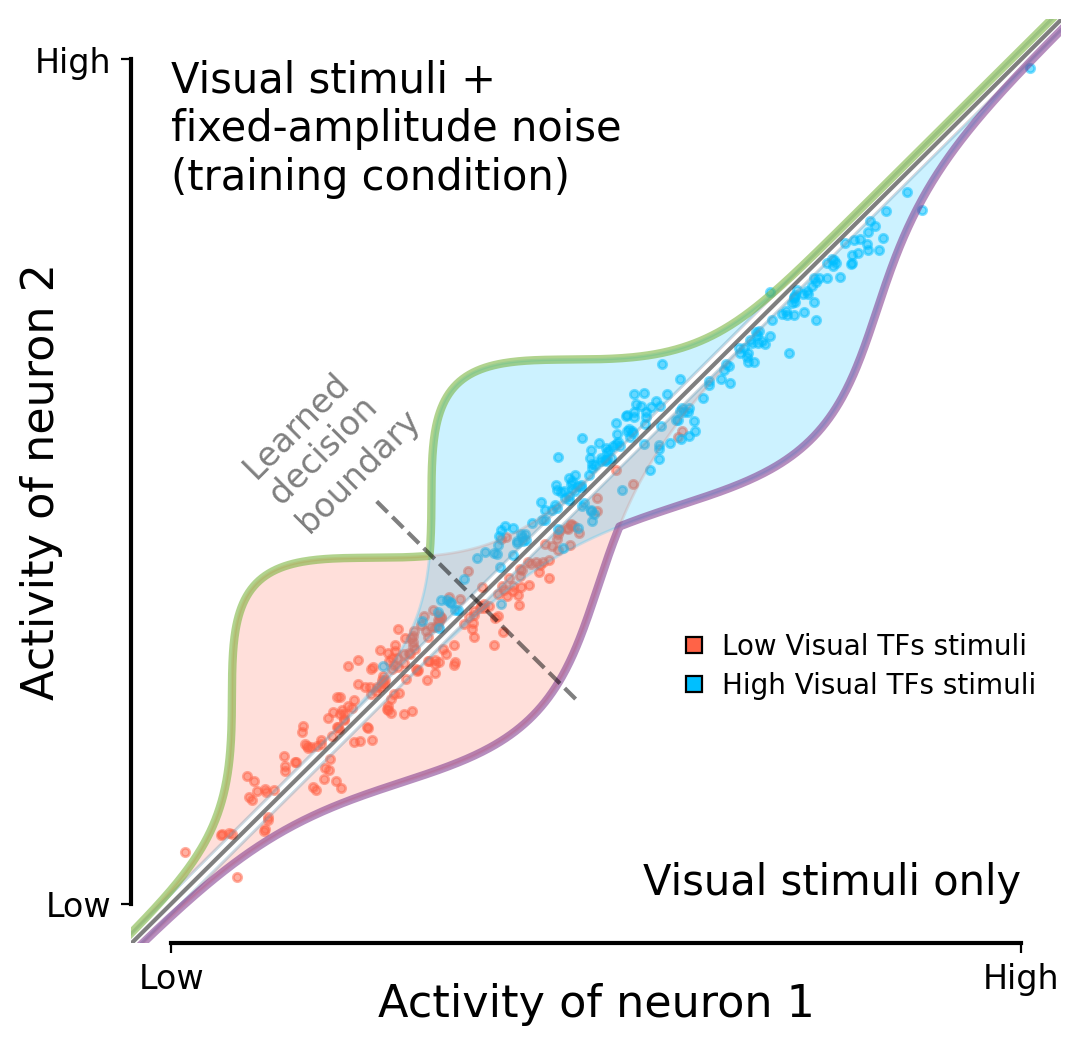

In [32]:
from scipy.stats import norm 
import matplotlib.patches as mpatches

mult = 1.4
N = 100

jitter_small = 0.02
jitter_big = 0.05

sigma=0.35

signal_1 = np.random.normal(1,sigma,N)
signal_2 = np.random.normal(2,sigma,N)

fig, ax = plt.subplots(figsize = (6,6), dpi = 200)

jitter = jitter_small + np.abs(np.random.normal(0,0.05,N))
ax.scatter(signal_1-jitter,signal_1+jitter, color = 'tomato', marker = '.', alpha = 0.5, label = "Measurements \nfor low frequency \nstimuli")
ax.scatter(signal_2-jitter,signal_2+jitter, color = 'deepskyblue', marker = '.', alpha = 0.5, label = "Measurements \nfor high frequency \nstimuli")
ax.scatter((signal_1)*mult+jitter,(signal_1)*mult-jitter, color = 'tomato', marker = '.', alpha = 0.5)
ax.scatter((signal_2)*mult+jitter,(signal_2)*mult-jitter, color = 'deepskyblue', marker = '.', alpha = 0.5)


label_row = ['Low Visual TFs stimuli','High Visual TFs stimuli']
rows = [mpatches.Patch(color=c) for c in ['tomato', 'deepskyblue']]
rows = [plt.plot([], [], "s", markerfacecolor=c,
                    markeredgecolor='k', markeredgewidth=.8)[0] for c in ['tomato', 'deepskyblue']]
ax.legend(labels=label_row, handles=rows, loc="center right", bbox_to_anchor=(1, 0.3),fontsize = 10, frameon = False, ncol = 1, labelspacing = 0.4, handletextpad=0.01)

def gaus_rot(mean,sig,theta,x):
    angle_sign = np.sign(180-theta)
    theta = theta - (angle_sign==-1)*180
    mean = mean/np.cos(np.deg2rad(theta))
    sig = sig/np.cos(np.deg2rad(theta))
    y =  angle_sign*1*norm.pdf(x, mean, sig)
    x_prime = x * np.cos(np.deg2rad(theta)) - y * np.sin(np.deg2rad(theta))
    y_prime = x * np.sin(np.deg2rad(theta)) + y * np.cos(np.deg2rad(theta))
    return x_prime,y_prime+angle_sign * jitter_big

theta = 45

curve0 = gaus_rot(1,sigma,theta,np.arange(-0.4,8, 0.01))
ax.fill_between(curve0[0],curve0[0]+jitter_big,curve0[1], color = 'tomato', alpha = 0.2)
curve1 = gaus_rot(2,sigma,theta,np.arange(-0.4,8, 0.01))
ax.fill_between(curve1[0],curve1[0]+jitter_big,curve1[1], color = 'deepskyblue', alpha = 0.2)
curve2 = gaus_rot(1*mult,sigma*mult,180+theta,np.arange(-0.4,8, 0.01))
ax.fill_between(curve2[0],curve2[1],curve2[0]-jitter_big, color = 'tomato', alpha = 0.2)
curve3 = gaus_rot(2*mult,sigma*mult,180+theta,np.arange(-0.4,8, 0.01))
ax.fill_between(curve3[0],curve3[1],curve3[0]-jitter_big, color = 'deepskyblue', alpha = 0.2)

plt.plot(np.concatenate((curve0[0][:np.sum(curve0[1]>curve1[1])], curve1[0][np.sum(curve0[1]>curve1[1]):])),np.maximum(curve1[1],curve0[1]), color = colormap[-1], linewidth = 3, alpha = 0.55)
plt.plot(np.concatenate((curve2[0][:np.sum(curve2[1]<curve3[1])], curve3[0][np.sum(curve2[1]<curve3[1]):])),np.minimum(curve3[1],curve2[1]), color = colormap[0], linewidth = 3, alpha = 0.55)

ax.plot([-0.2,max(signal_2)*mult+0.2],[-0.2,max(signal_2)*mult+0.2], color = 'k',alpha = 0.5)

ax.text(0,max(signal_2)*mult, "Visual stimuli + \nfixed-amplitude noise \n(training condition)", fontsize = 15, horizontalalignment = 'left', verticalalignment = 'top')
ax.text(max(signal_2)*mult,0, "Visual stimuli only", fontsize = 15, horizontalalignment = 'right', verticalalignment = 'bottom')

thresh = 1.53
ax.plot([thresh-0.5,thresh+0.5],[thresh+0.5,thresh-0.5], color = 'k', linestyle = 'dashed',alpha=0.5)
ax.text(thresh-1.2,thresh+0.35, "Learned\ndecision \nboundary", fontsize = 12, rotation = 45, alpha=0.5)

exempl = 1.4

ax.set_xlim([0-0.2,max(mult*signal_2)+0.2])
ax.set_ylim([0-0.2,max(mult*signal_2)+0.2])

ax.set_xlabel("Activity of neuron 1", fontsize = 16, labelpad = -5)
ax.set_ylabel("Activity of neuron 2", fontsize = 16, labelpad = -10)

ax.set_xticks(np.linspace(0,max(mult*signal_2),2))
ax.set_yticks(np.linspace(0,max(mult*signal_2),2))

ax.set_xticklabels(["Low","High"], fontsize = 12)
ax.set_yticklabels(["Low","High"], fontsize = 12)


ax.spines.bottom.set_bounds(0,np.max(signal_2)*mult)
ax.spines.left.set_bounds(0,np.max(signal_2)*mult)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines['left'].set_linewidth(1.5)   
ax.spines['bottom'].set_linewidth(1.5)

#### One Neuron

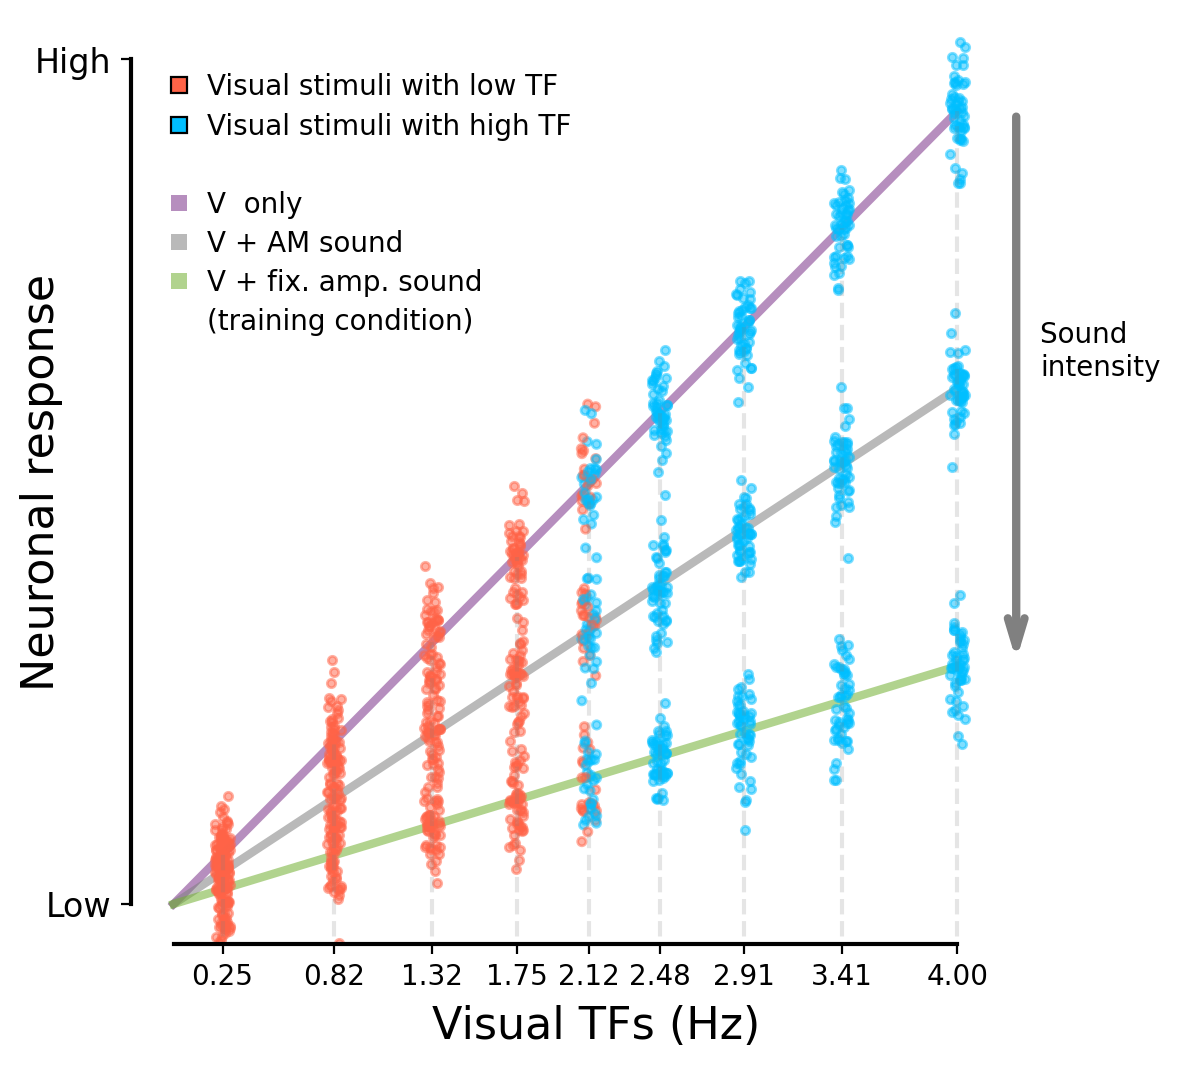

In [33]:
import matplotlib.patches as mpatches

mult = 1.4

jitter_small = 0.08
jitter_big = 0.5

N = 50
mu_V = 1
mu_AV = 0.65
mu_f = 0.3
sigma=0.15

v_freq = data["Frequency"].unique()[:-1]    

fig, ax = plt.subplots(figsize = (6,6), dpi = 200)

ax.set_xticks(v_freq)
ax.set_yticks(np.linspace(0,max(mult*signal_2),2))
ax.set_yticklabels(["Low","High"], fontsize = 12)
ax.set_ylabel("Neuronal response", fontsize = 16, labelpad = -10)
ax.set_xlabel("Visual TFs (Hz)", fontsize = 16, labelpad = 5)
ax.set_ylim([0-0.2,max(mult*signal_2)+0.2])
ax.spines.bottom.set_bounds(0,4)
ax.spines.left.set_bounds(0,np.max(signal_2)*mult)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines['left'].set_linewidth(1.5)   
ax.spines['bottom'].set_linewidth(1.5)

line_V = ax.plot([0,v_freq[-1]], [0,v_freq[-1]*mu_V], c= colormap[0],zorder=-10, linewidth = 3, alpha = 0.55,label="a")[0]
line_AV = ax.plot([0,v_freq[-1]], [0,v_freq[-1]*mu_AV], c= colormap[2],zorder=-10, linewidth = 3, alpha = 0.55,label="a")[0]
line_f = ax.plot([0,v_freq[-1]], [0,v_freq[-1]*mu_f], c= colormap[-1],zorder=-10, linewidth = 3, alpha = 0.55,label="b")[0]

label_row = ['Visual stimuli with low TF','Visual stimuli with high TF']
square_handles = [plt.plot([], [], "s", markerfacecolor=c,
                             markeredgecolor='k', markeredgewidth=.8)[0] for c in ['tomato', 'deepskyblue']]
lines_handles = [plt.plot([], [], "s", markerfacecolor=c,
                             markeredgecolor=c, markeredgewidth=.0,alpha=0.55,)[0] for c in ["w", colormap[0], colormap[2],  colormap[-1], "w"]]
all_handles = square_handles + lines_handles
[0]
all_labels = label_row + ["","V  only", "V + AM sound", "V + fix. amp. sound", "(training condition)"]

ax.legend(labels=all_labels, handles=all_handles, loc="center right", bbox_to_anchor=(0.5, 0.8), fontsize=10, frameon=False, ncol=1, labelspacing=0.4, handletextpad=0.01)


color_points = np.array([ 'tomato', 'deepskyblue'])
label_row = ['Low Visual TFs stimuli','High Visual TFs stimuli']
for f in v_freq:
    if f<2.12: 
        color_p = color_points[0]
    elif f>2.13:
        color_p = color_points[1]
    else:
        color_p = color_points[np.random.randint(0,2,N)]
    signal_V = np.random.normal(f*mu_V,sigma,N)
    signal_AV = np.random.normal(f*mu_AV,sigma,N)
    signal_f = np.random.normal(f*mu_f,sigma,N)
    x_f = f+(np.random.random(N)-0.5)*jitter_small
    ax.scatter(x_f, signal_V, color = color_p, marker = '.', alpha = 0.5, label = "Measurements \nfor low frequency \nstimuli")
    ax.scatter(x_f, signal_AV, color = color_p, marker = '.', alpha = 0.5, label = "Measurements \nfor low frequency \nstimuli")
    ax.scatter(x_f, signal_f, color = color_p, marker = '.', alpha = 0.5, label = "Measurements \nfor low frequency \nstimuli")
    ax.vlines(f,-1,mu_V*f, color="Gray",alpha=0.2,linestyle="dashed")

x_arrow = 4.3

arr = mpatches.FancyArrowPatch((x_arrow, 4*mu_V), (x_arrow, 4*mu_f),
                               arrowstyle='->,head_width=.15,head_length=.5', mutation_scale=20,color="Gray", linewidth = 3)
ax.add_patch(arr)
ax.annotate("Sound \nintensity", (1.95, .5), xycoords=arr, ha='left', va='bottom')


plt.savefig("Single_neuron_model_FIG.svg", format = "svg")

### Sigmoids

#### Comparison

In [39]:
idata_main = {k: idata[k] for k in set(["5γ_1σ","5γ_5σ","11γ_1σ","1γ_5σ", "1γ_1σ"])}
comparison_main = az.compare(idata_main, ic="loo")

comparison_main_diff = comparison_main.elpd_diff.values[::-1]
comparison_main_dse = comparison_main.dse.values[::-1]
comp_names = ["5γ, 1σ", "5γ, 5σ", "11γ, 1σ", "1γ, 5σ", "1γ, 1σ"]
comp_names.reverse()

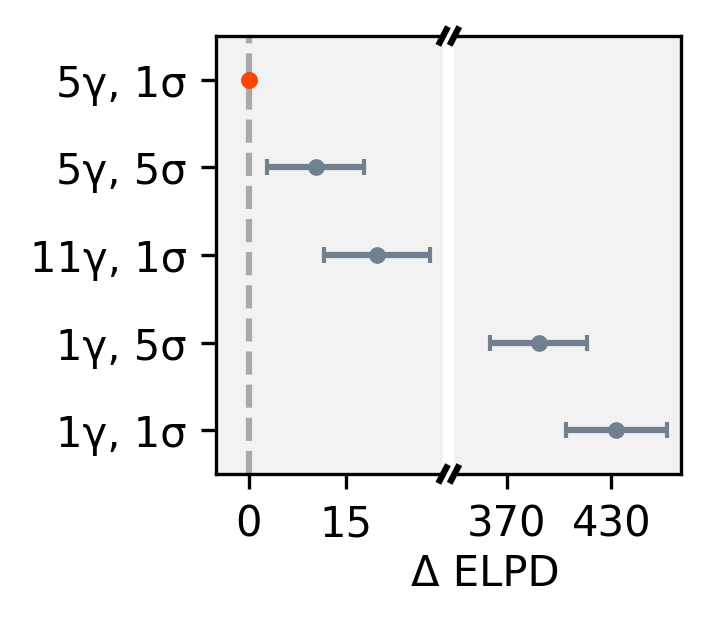

In [40]:
def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, facecolor='w', figsize=(2, 2),subplot_kw=dict(facecolor=".95"), dpi=300)
plt.subplots_adjust(wspace=0, hspace=0.0)

ax1.set_xlim(-5,30)
ax2.set_xlim(340,470)
ax1.set_ylim(-0.5,4.5)
ax2.set_ylim(-0.5,4.5)

for ax in (ax1, ax2):
    ax.errorbar(comparison_main_diff,comp_names, xerr = comparison_main_dse, fmt = '.', capsize = 2, color="slategray")
ax1.axvline(comparison_main_diff[-1], linestyle = 'dashed', color = 'k', alpha=0.3)
ax1.scatter(comparison_main_diff[-1],comp_names[-1], color="orangered", marker=".", zorder=10)    
    
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.yaxis.tick_right()
ax2.set_yticks([])
ax1.set_xticks([0,15])
ax2.set_xticks([370,430])

d = 0.015
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d, 1+d), (1-d, 1+d), **kwargs)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax2.plot((- d, d), (- d, d), **kwargs)

plt.subplots_adjust(bottom=0.15, wspace=0.05)

fig.text(0.45, -0.015, r'Δ ELPD', va='center', rotation='horizontal')

plt.show()

#### Match with Data

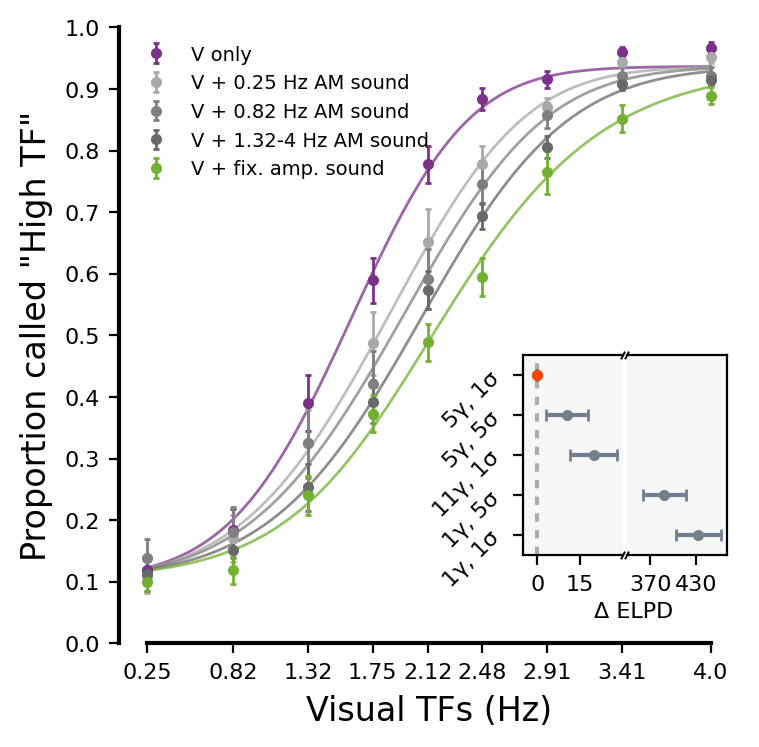

In [41]:
from scipy.special import erf

def phi(x):
    return (1+erf(x/np.sqrt(2)))/2

dim = idata["5γ_1σ"].posterior["ϵ"].dims[3]
eps_0 = idata["5γ_1σ"].posterior["ϵ"].sel(**{dim:0})
eps_1 = idata["5γ_1σ"].posterior["ϵ"].sel(**{dim:1})
gamma = idata["5γ_1σ"].posterior["γ"]
sigma = idata["5γ_1σ"].posterior["σ"]

v_freqs = data["Frequency"].unique()[:-1]

fig, ax = plt.subplots(figsize = (4,4), dpi = 200)

for i in data["Noise_5_types"].unique():
    N_Tot = np.array([[len(data.loc[(data["Frequency"] == f) & (data['Noise_5_types'] == i) & (data['Rat'] == r)]) for r in data["Rat"].unique()] for f in v_freqs])
    N_High = np.array([[len(data.loc[(data["Frequency"] == f) & (data['Noise_5_types'] == i) & (data['Response'] == 1) & (data['Rat'] == r)]) for r in data["Rat"].unique()] for f in v_freqs])
    mean_perc = np.mean(N_High/N_Tot, axis = 1)
    std_perc = np.std(N_High/N_Tot, axis = 1)/np.sqrt(len(data["Rat"].unique()-1))
    ax.errorbar(v_freqs,mean_perc, yerr = std_perc, fmt = ".", color = colormap[i], label = legends[i], capsize = 1, elinewidth = 1., capthick = 1., linewidth = 1.)
    curve = (eps_0 + eps_1 * phi((gamma[:,:,i] * xr.DataArray(np.linspace(v_freqs.min(),v_freqs.max(),100)) - 2.12)/sigma)).mean(dim=("chain","draw","Rat")) 
    ax.plot(np.linspace(v_freqs.min(),v_freqs.max(),100), curve,ls="-", lw=1,alpha=0.75, color = colormap[i])
    
plt.legend(loc = "upper left", fontsize = 7,frameon=False)
ax.set_xlabel("Visual TFs (Hz)", fontsize = 12)
ax.set_ylabel('Proportion called "High TF"', fontsize = 12)

ax.set_ylim(0,1)
ax.set_xticks(v_freqs)
ax.set_xticklabels(v_freqs, fontsize = 8)

ax.set_yticks(np.linspace(0,1,11))
ax.set_yticklabels(np.linspace(0,1,11).round(1), fontsize = 8)

ax.spines.bottom.set_bounds(v_freqs.min(), v_freqs.max())
ax.spines.left.set_bounds(0,1)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines['left'].set_linewidth(1.5)   
ax.spines['bottom'].set_linewidth(1.5)

# Plot the subplot data
left, bottom, width, height = [0.63, 0.22, 0.25, 0.25]
ax1 = fig.add_axes([left, bottom, width/2, height],facecolor=".97")
ax2 = fig.add_axes([left+width/2+0.005, bottom, width/2, height], facecolor=".97")


ax1.set_xlim(-5,30)
ax2.set_xlim(340,470)
ax1.set_ylim(-0.5,4.5)     
ax2.set_ylim(-0.5,4.5)



for ax in (ax1, ax2):
    ax.errorbar(comparison_main_diff,comp_names, xerr = comparison_main_dse, fmt = '.', capsize = 2, color="slategray")
ax1.axvline(comparison_main_diff[-1], linestyle = (0,(2,2)), color = 'k', alpha=0.3)
ax1.scatter(comparison_main_diff[-1],comp_names[-1], color="orangered", marker=".", zorder=10)
 
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.yaxis.tick_right()
ax2.set_yticks([])
ax1.set_xticks([0,15])
ax2.set_xticks([370,430])


for label in ax1.get_yticklabels():
    label.set_rotation(45)
    label.set_fontsize(8)
    
for label in ax1.get_xticklabels():
    label.set_fontsize(8)
for label in ax2.get_xticklabels():
    label.set_fontsize(8)


d = 0.015

kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False, linewidth=0.7)
ax1.plot((1-d, 1+d), (1-d, 1+d), **kwargs)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)

kwargs.update(transform=ax2.transAxes) 
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax2.plot((- d, d), (- d, d), **kwargs)

ax1.text(20, -1.9, r'Δ ELPD', va='center', rotation='horizontal', fontsize = 8)
plt.show()

#### Posterior Predictive Sigmoids

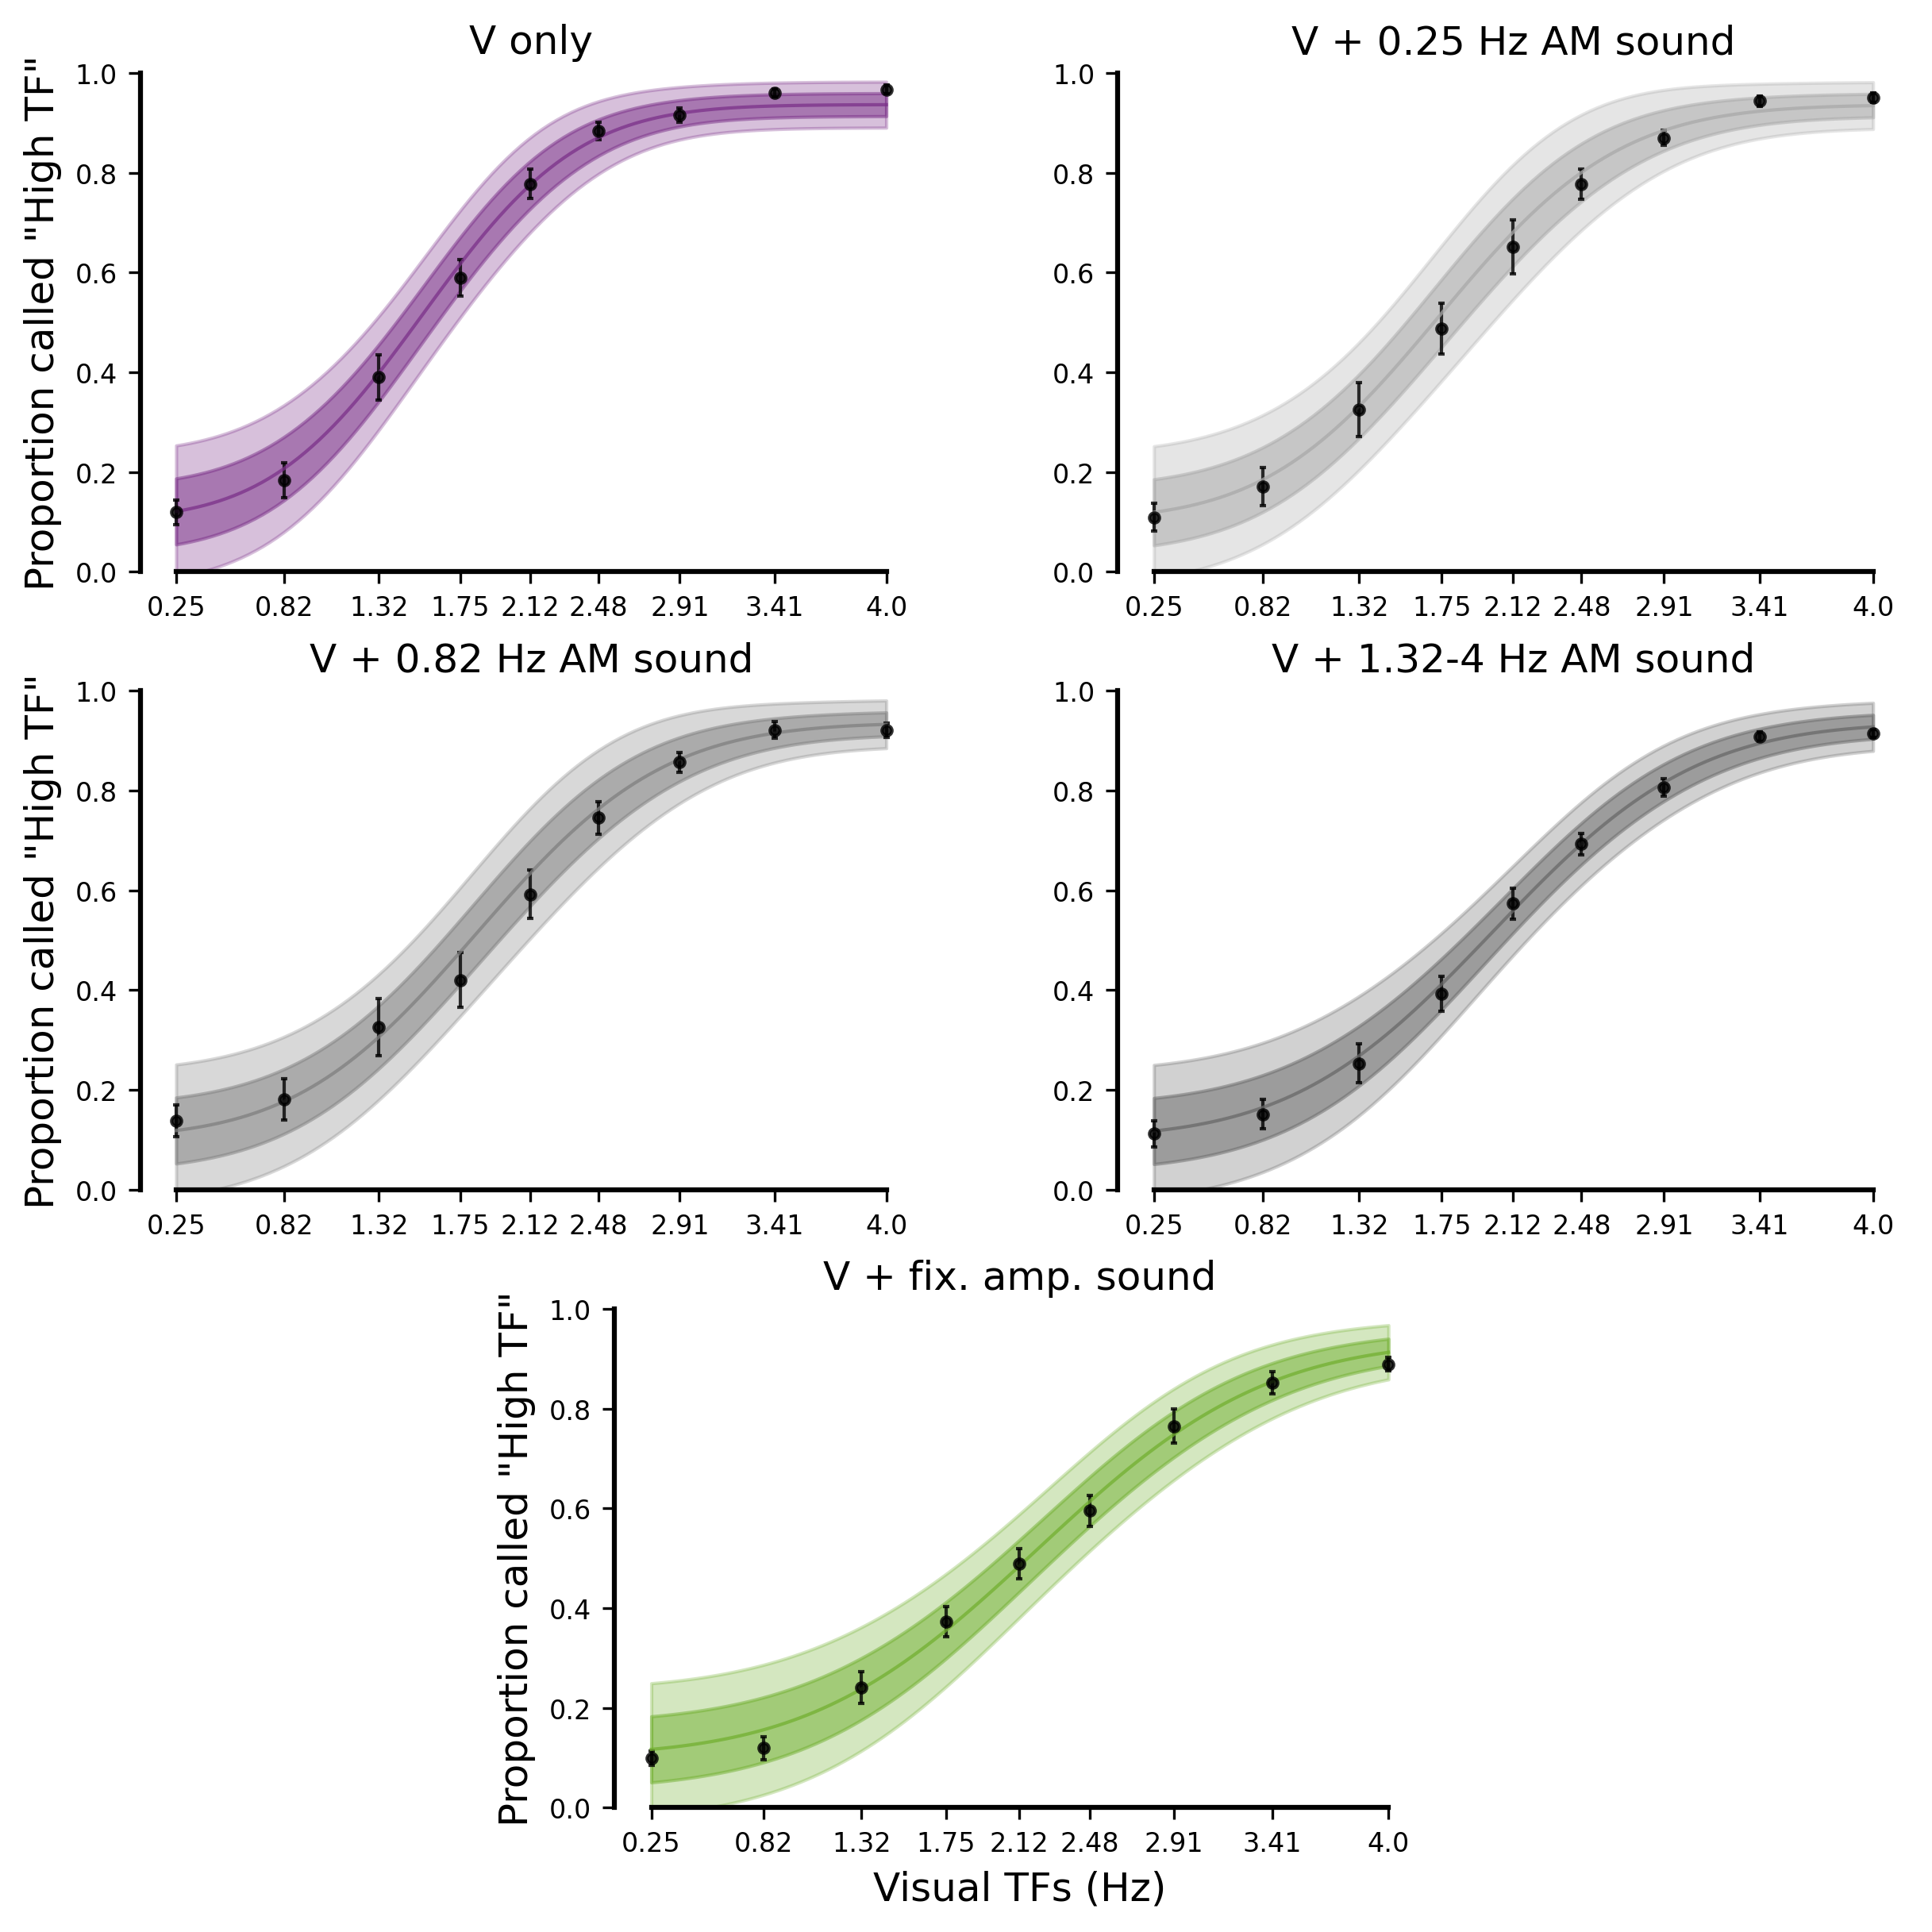

In [42]:
from scipy.special import erf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def phi(x):
    return (1+erf(x/np.sqrt(2)))/2

dim = idata["5γ_1σ"].posterior["ϵ"].dims[3]
eps_0 = idata["5γ_1σ"].posterior["ϵ"].sel(**{dim:0})
eps_1 = idata["5γ_1σ"].posterior["ϵ"].sel(**{dim:1})
gamma = idata["5γ_1σ"].posterior["γ_μ"]
sigma = idata["5γ_1σ"].posterior["σ_μ"]

v_freqs = data["Frequency"].unique()[:-1]

fig = plt.figure(figsize=(8, 8), constrained_layout=True, dpi=300)

gs = gridspec.GridSpec(3, 4, figure=fig)
ax = {}
ax[0] = fig.add_subplot(gs[0, :2])
ax[1] = fig.add_subplot(gs[0, 2:])
ax[2] = fig.add_subplot(gs[1, :2])
ax[3] = fig.add_subplot(gs[1, 2:])
ax[4] = fig.add_subplot(gs[2, 1:3])

for i in data["Noise_5_types"].unique():
    ax[i].set_title(legends[i])
    N_Tot = np.array([[len(data.loc[(data["Frequency"] == f) & (data['Noise_5_types'] == i) & (data['Rat'] == r)]) for r in data["Rat"].unique()] for f in v_freqs])
    N_High = np.array([[len(data.loc[(data["Frequency"] == f) & (data['Noise_5_types'] == i) & (data['Response'] == 1) & (data['Rat'] == r)]) for r in data["Rat"].unique()] for f in v_freqs])
    mean_perc = np.mean(N_High/N_Tot, axis = 1)
    std_perc = np.std(N_High/N_Tot, axis = 1)/np.sqrt(len(data["Rat"].unique()-1))
    ax[i].errorbar(v_freqs,mean_perc, yerr = std_perc, fmt = ".", color = "k", label = legends[i], capsize = 1, elinewidth = 1., capthick = 1., linewidth = 1., alpha=0.8)
    curve = (eps_0 + eps_1 * phi((gamma[:,:,i] * xr.DataArray(np.linspace(v_freqs.min(),v_freqs.max(),100)) - 2.12)/sigma)).mean(dim=("chain","draw","Rat")) 
    curve_sd = (eps_0 + eps_1 * phi((gamma[:,:,i] * xr.DataArray(np.linspace(v_freqs.min(),v_freqs.max(),100)) - 2.12)/sigma)).std(dim=("chain","draw","Rat")) 
    ax[i].plot(np.linspace(v_freqs.min(),v_freqs.max(),100), curve,ls="-", lw=1,alpha=0.75, color = colormap[i])
    ax[i].fill_between(np.linspace(v_freqs.min(),v_freqs.max(),100), curve-curve_sd, curve+curve_sd, color = colormap[i], alpha = 0.5)
    ax[i].fill_between(np.linspace(v_freqs.min(),v_freqs.max(),100), curve-2*curve_sd, curve+2*curve_sd, color = colormap[i], alpha = 0.3)
    
    if i==4: ax[i].set_xlabel("Visual TFs (Hz)", fontsize = 12)
    if i%2==0: ax[i].set_ylabel('Proportion called "High TF"', fontsize = 12)
    
    ax[i].set_ylim(0,1)
    ax[i].set_xticks(v_freqs)
    ax[i].set_xticklabels(v_freqs, fontsize = 8)
    
    ax[i].set_yticks(np.linspace(0,1,6))
    ax[i].set_yticklabels(np.linspace(0,1,6).round(1), fontsize = 8)
    
    ax[i].spines.bottom.set_bounds(v_freqs.min(), v_freqs.max())
    ax[i].spines.left.set_bounds(0,1)
    ax[i].spines.right.set_visible(False)
    ax[i].spines.top.set_visible(False)
    ax[i].spines['left'].set_linewidth(1.5)   
    ax[i].spines['bottom'].set_linewidth(1.5)

plt.savefig("extended_9_Posterior_Predictive.png")

plt.show()

#### Prior Predictive Sigmoids

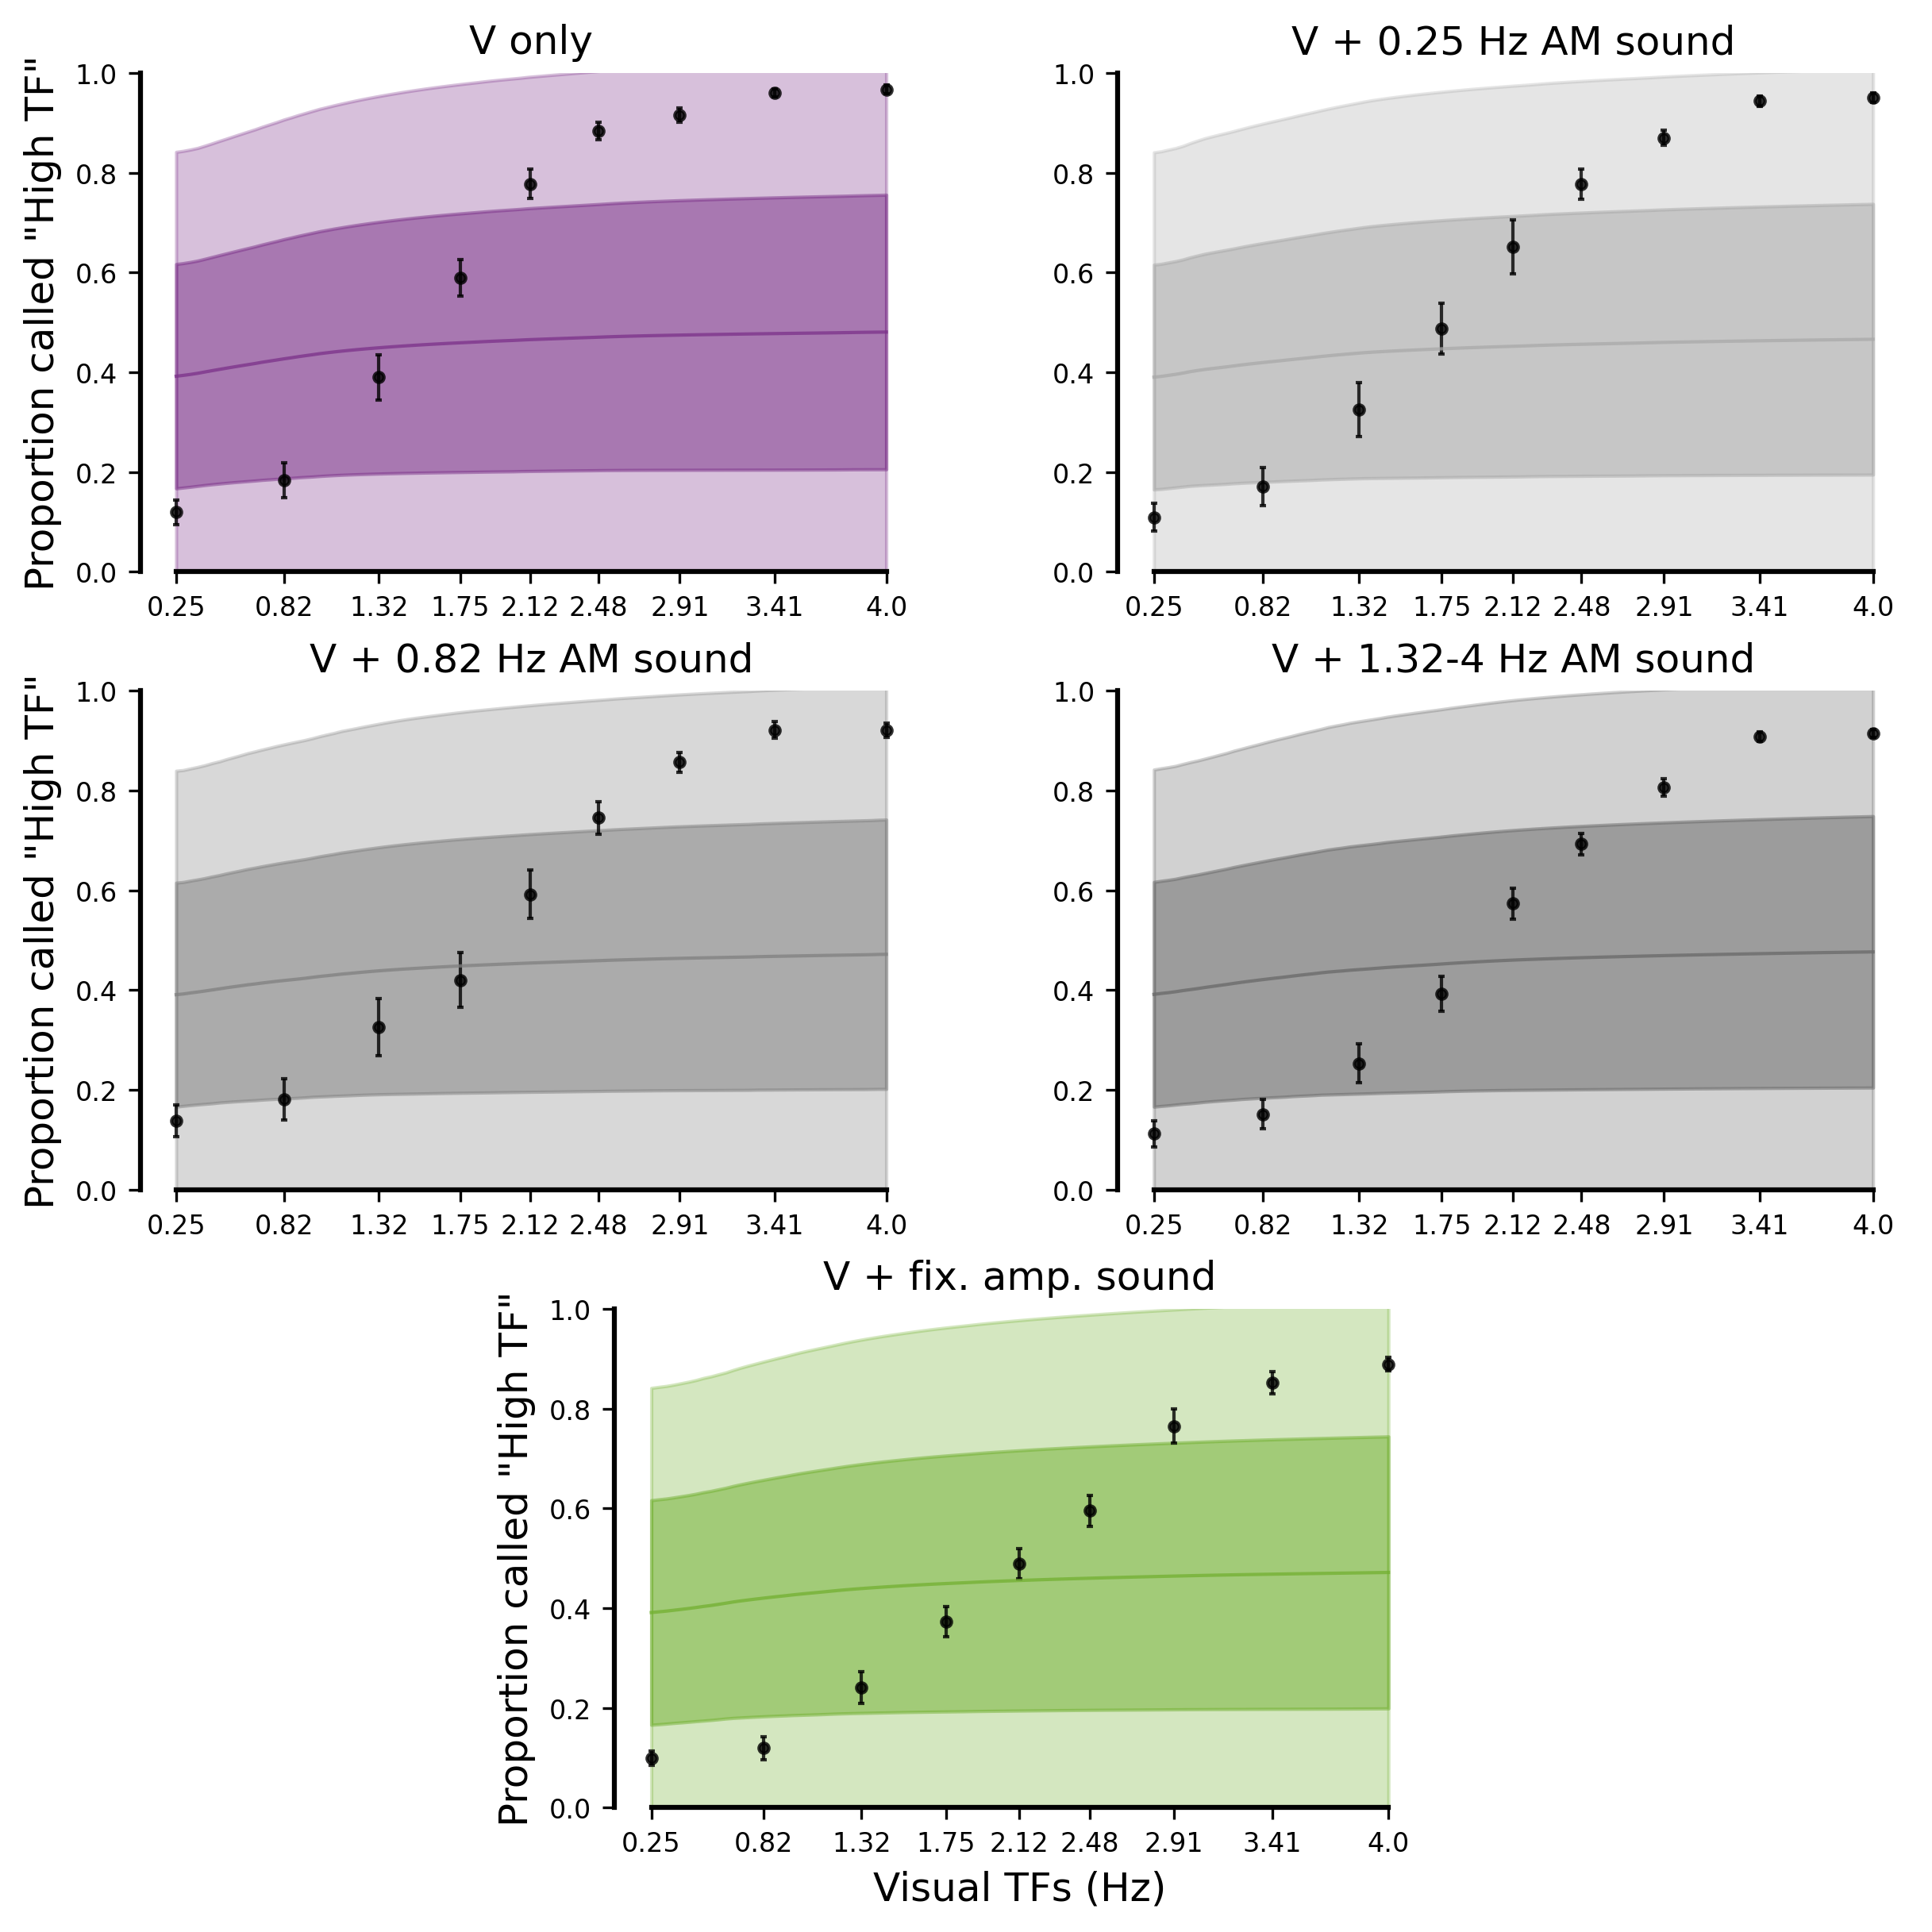

In [43]:
from scipy.special import erf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def phi(x):
    return (1+erf(x/np.sqrt(2)))/2

dim = ppc["5γ_1σ"].prior["ϵ"].dims[3]
eps_0 = ppc["5γ_1σ"].prior["ϵ"].sel(**{dim:0})
eps_1 = ppc["5γ_1σ"].prior["ϵ"].sel(**{dim:1})
gamma = ppc["5γ_1σ"].prior["γ_μ"]
sigma = ppc["5γ_1σ"].prior["σ_μ"]

v_freqs = data["Frequency"].unique()[:-1]

fig = plt.figure(figsize=(8, 8), constrained_layout=True, dpi=300)

gs = gridspec.GridSpec(3, 4, figure=fig)
ax = {}
ax[0] = fig.add_subplot(gs[0, :2])
ax[1] = fig.add_subplot(gs[0, 2:])
ax[2] = fig.add_subplot(gs[1, :2])
ax[3] = fig.add_subplot(gs[1, 2:])
ax[4] = fig.add_subplot(gs[2, 1:3])

for i in data["Noise_5_types"].unique():
    ax[i].set_title(legends[i])
    N_Tot = np.array([[len(data.loc[(data["Frequency"] == f) & (data['Noise_5_types'] == i) & (data['Rat'] == r)]) for r in data["Rat"].unique()] for f in v_freqs])
    N_High = np.array([[len(data.loc[(data["Frequency"] == f) & (data['Noise_5_types'] == i) & (data['Response'] == 1) & (data['Rat'] == r)]) for r in data["Rat"].unique()] for f in v_freqs])
    mean_perc = np.mean(N_High/N_Tot, axis = 1)
    std_perc = np.std(N_High/N_Tot, axis = 1)/np.sqrt(len(data["Rat"].unique()-1))
    ax[i].errorbar(v_freqs,mean_perc, yerr = std_perc, fmt = ".", color = "k", label = legends[i], capsize = 1, elinewidth = 1., capthick = 1., linewidth = 1., alpha=0.8)
    curve = (eps_0 + eps_1 * phi((gamma[:,:,i] * xr.DataArray(np.linspace(v_freqs.min(),v_freqs.max(),100)) - 2.12)/sigma)).mean(dim=("chain","draw","Rat")) 
    curve_sd = (eps_0 + eps_1 * phi((gamma[:,:,i] * xr.DataArray(np.linspace(v_freqs.min(),v_freqs.max(),100)) - 2.12)/sigma)).std(dim=("chain","draw","Rat")) 
    ax[i].plot(np.linspace(v_freqs.min(),v_freqs.max(),100), curve,ls="-", lw=1,alpha=0.75, color = colormap[i])
    ax[i].fill_between(np.linspace(v_freqs.min(),v_freqs.max(),100), curve-curve_sd, curve+curve_sd, color = colormap[i], alpha = 0.5)
    ax[i].fill_between(np.linspace(v_freqs.min(),v_freqs.max(),100), curve-2*curve_sd, curve+2*curve_sd, color = colormap[i], alpha = 0.3)
    
    if i==4: ax[i].set_xlabel("Visual TFs (Hz)", fontsize = 12)
    if i%2==0: ax[i].set_ylabel('Proportion called "High TF"', fontsize = 12)
    
    ax[i].set_ylim(0,1)
    ax[i].set_xticks(v_freqs)
    ax[i].set_xticklabels(v_freqs, fontsize = 8)
    
    ax[i].set_yticks(np.linspace(0,1,6))
    ax[i].set_yticklabels(np.linspace(0,1,6).round(1), fontsize = 8)
    
    ax[i].spines.bottom.set_bounds(v_freqs.min(), v_freqs.max())
    ax[i].spines.left.set_bounds(0,1)
    ax[i].spines.right.set_visible(False)
    ax[i].spines.top.set_visible(False)
    ax[i].spines['left'].set_linewidth(1.5)   
    ax[i].spines['bottom'].set_linewidth(1.5)

plt.savefig("extended_8_Prior_Predictive.png")

plt.show()

### Sound Intensity

#### Intensity vs Gamma

In [44]:
freqs = data["Noise_Frequency"].unique()
rat_dBintensity_per_freq = np.zeros((len(data["Rat"].unique()), len(freqs)))

all_intensities = []
for r in data["Rat"].unique():
    data_rat = data[data["Rat"]==r]
    mean_intensities = []
    all_intensities_r = []
    for n_f in range(0,len(freqs)):
        data_rat_freq = data_rat[data_rat["Noise_Frequency"] == freqs[n_f]]
        RTs = data_rat_freq["RT"].values - MoRsT
        means = np.zeros_like(RTs)
        for i in np.arange(len(means)):
            means[i] = avg_decibel_intensity(freqs[n_f], RTs[i], chunks_len = int(nu_WN*0.005))
        mean_intensities.append(means.mean())
        all_intensities_r.append(means)
    rat_dBintensity_per_freq[r-1] = np.array(mean_intensities)
    all_intensities.append(all_intensities_r)

rat_intensity_per_type = np.zeros((len(data["Rat"].unique()), 5))
rat_intensity_per_type[:,:3] = rat_dBintensity_per_freq[:,:3]
rat_intensity_per_type[:,3] = np.mean(rat_dBintensity_per_freq[:,3:-1],axis=1)
rat_intensity_per_type[:,-1] = rat_dBintensity_per_freq[:,-1]
rat_intensity_per_type = rat_intensity_per_type.T

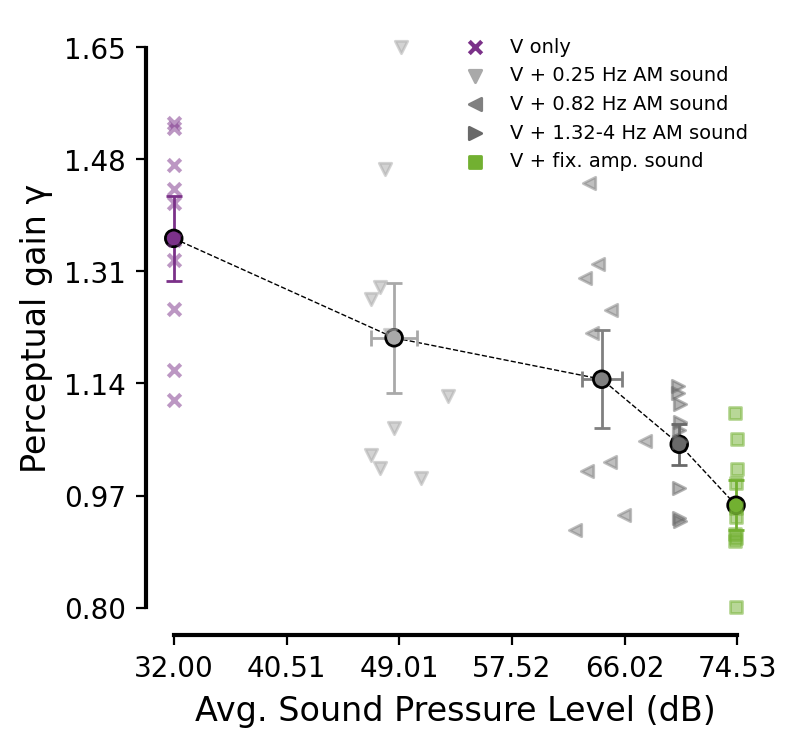

In [46]:
gamma5 = idata["5γ_1σ"].posterior["γ_μ"].mean(("chain","draw"))
gamma5_std = idata["5γ_1σ"].posterior["γ_μ"].std(("chain","draw"))
rat_gammas = idata["5γ_1σ"].posterior["γ"].mean(("chain","draw"))


mean_intensity_per_type = np.mean(rat_intensity_per_type, axis=1)
std_intensity_per_type = np.std(rat_intensity_per_type, axis=1)

fig, ax = plt.subplots(figsize=(4,4), dpi=200)
 
ax.plot(mean_intensity_per_type, gamma5, color="k", linewidth=0.5, zorder=-10,linestyle="dashed")
ax.scatter(mean_intensity_per_type,gamma5,c=colormap, edgecolors="black")

for i in range(5):
    ax.scatter(rat_intensity_per_type[i],rat_gammas[i], marker=markers[i], alpha=0.5, c=colormap[i], s=20, label=legends[i])
    ax.errorbar(mean_intensity_per_type[i],y=gamma5[i], xerr=std_intensity_per_type[i], yerr=gamma5_std[i], fmt='.', ecolor=colormap[i], capsize=3, elinewidth=1,zorder=-10)

ax.set_ylabel("Perceptual gain γ", fontsize=12)
ax.set_xlabel("Avg. Sound Pressure Level (dB)", fontsize=12)

ax.set_yticks(np.linspace(np.min(rat_gammas), np.max(rat_gammas),6).round(2))
ax.set_xticks(np.linspace(np.min(rat_intensity_per_type), np.max(rat_intensity_per_type+0.005),6).round(2))

ax.spines.bottom.set_bounds(np.min(rat_intensity_per_type)+ 0.0005,np.max(rat_intensity_per_type+0.005).round(2)-0.0005)
ax.spines.left.set_bounds(np.min(rat_gammas),np.max(rat_gammas)-0.0005)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines['left'].set_linewidth(1.5)   
ax.spines['bottom'].set_linewidth(1.5)

leg = plt.legend(fontsize=7, frameon=False)
for lh in leg.legend_handles: 
    lh.set_alpha(1)

#### Linear version of Intensity vs Gamma

In [47]:
idata_linear = {k: idata[k] for k in set(["5γ_1σ","Linear"])}
comparison_linear = az.compare(idata_linear, ic="loo")

comparison_linear_diff = comparison_linear.elpd_diff.values[::-1]
comparison_linear_dse = comparison_linear.dse.values[::-1]
comp_names = ["5γ, 1σ", "Linear γ"]
comp_names.reverse()

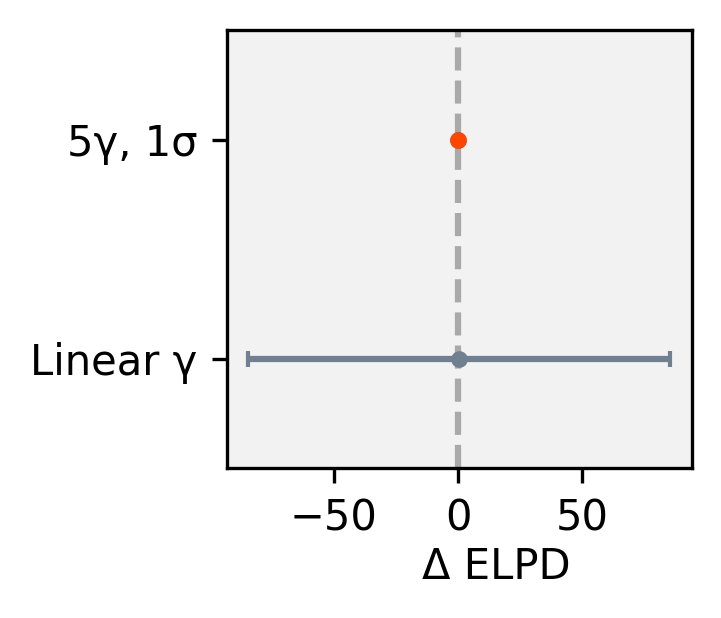

In [48]:
def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)

fig, ax1 = plt.subplots(1, 1, sharey=False, facecolor='w', figsize=(2, 2),subplot_kw=dict(facecolor=".95"), dpi=300)
plt.subplots_adjust(wspace=0, hspace=0.0)

ax1.set_ylim(-0.5,1.5)
ax2.set_ylim(-0.5,1.5)

ax1.errorbar(comparison_linear_diff,comp_names, xerr = comparison_linear_dse, fmt = '.', capsize = 2, color="slategray")
ax1.axvline(comparison_linear_diff[-1], linestyle = 'dashed', color = 'k', alpha=0.3)
ax1.scatter(comparison_linear_diff[-1],comp_names[-1], color="orangered", marker=".", zorder=10)    

plt.subplots_adjust(bottom=0.15, wspace=0.05)

fig.text(0.45, -0.015, r'Δ ELPD', va='center', rotation='horizontal')

plt.show()

In [49]:
alpha5 = idata["Linear"].posterior["α_γ_μ_standard"].stack(sample=("chain", "draw")).values
beta5 = idata["Linear"].posterior["β_γ_μ_standard"].stack(sample=("chain", "draw")).values

β_γ_μ = (beta5 / r_in_per_type_std)    
α_γ_μ = (alpha5 - (beta5 * r_in_per_type_mean) / r_in_per_type_std)

print("Intercept: ", α_γ_μ.mean(), "±",α_γ_μ.std())
print("Slope: ", β_γ_μ.mean(), "±",β_γ_μ.std())

Intercept:  1.6363152574673658 ± 0.08358735236432421
Slope:  -0.008582557074888787 ± 0.0013679829061929711


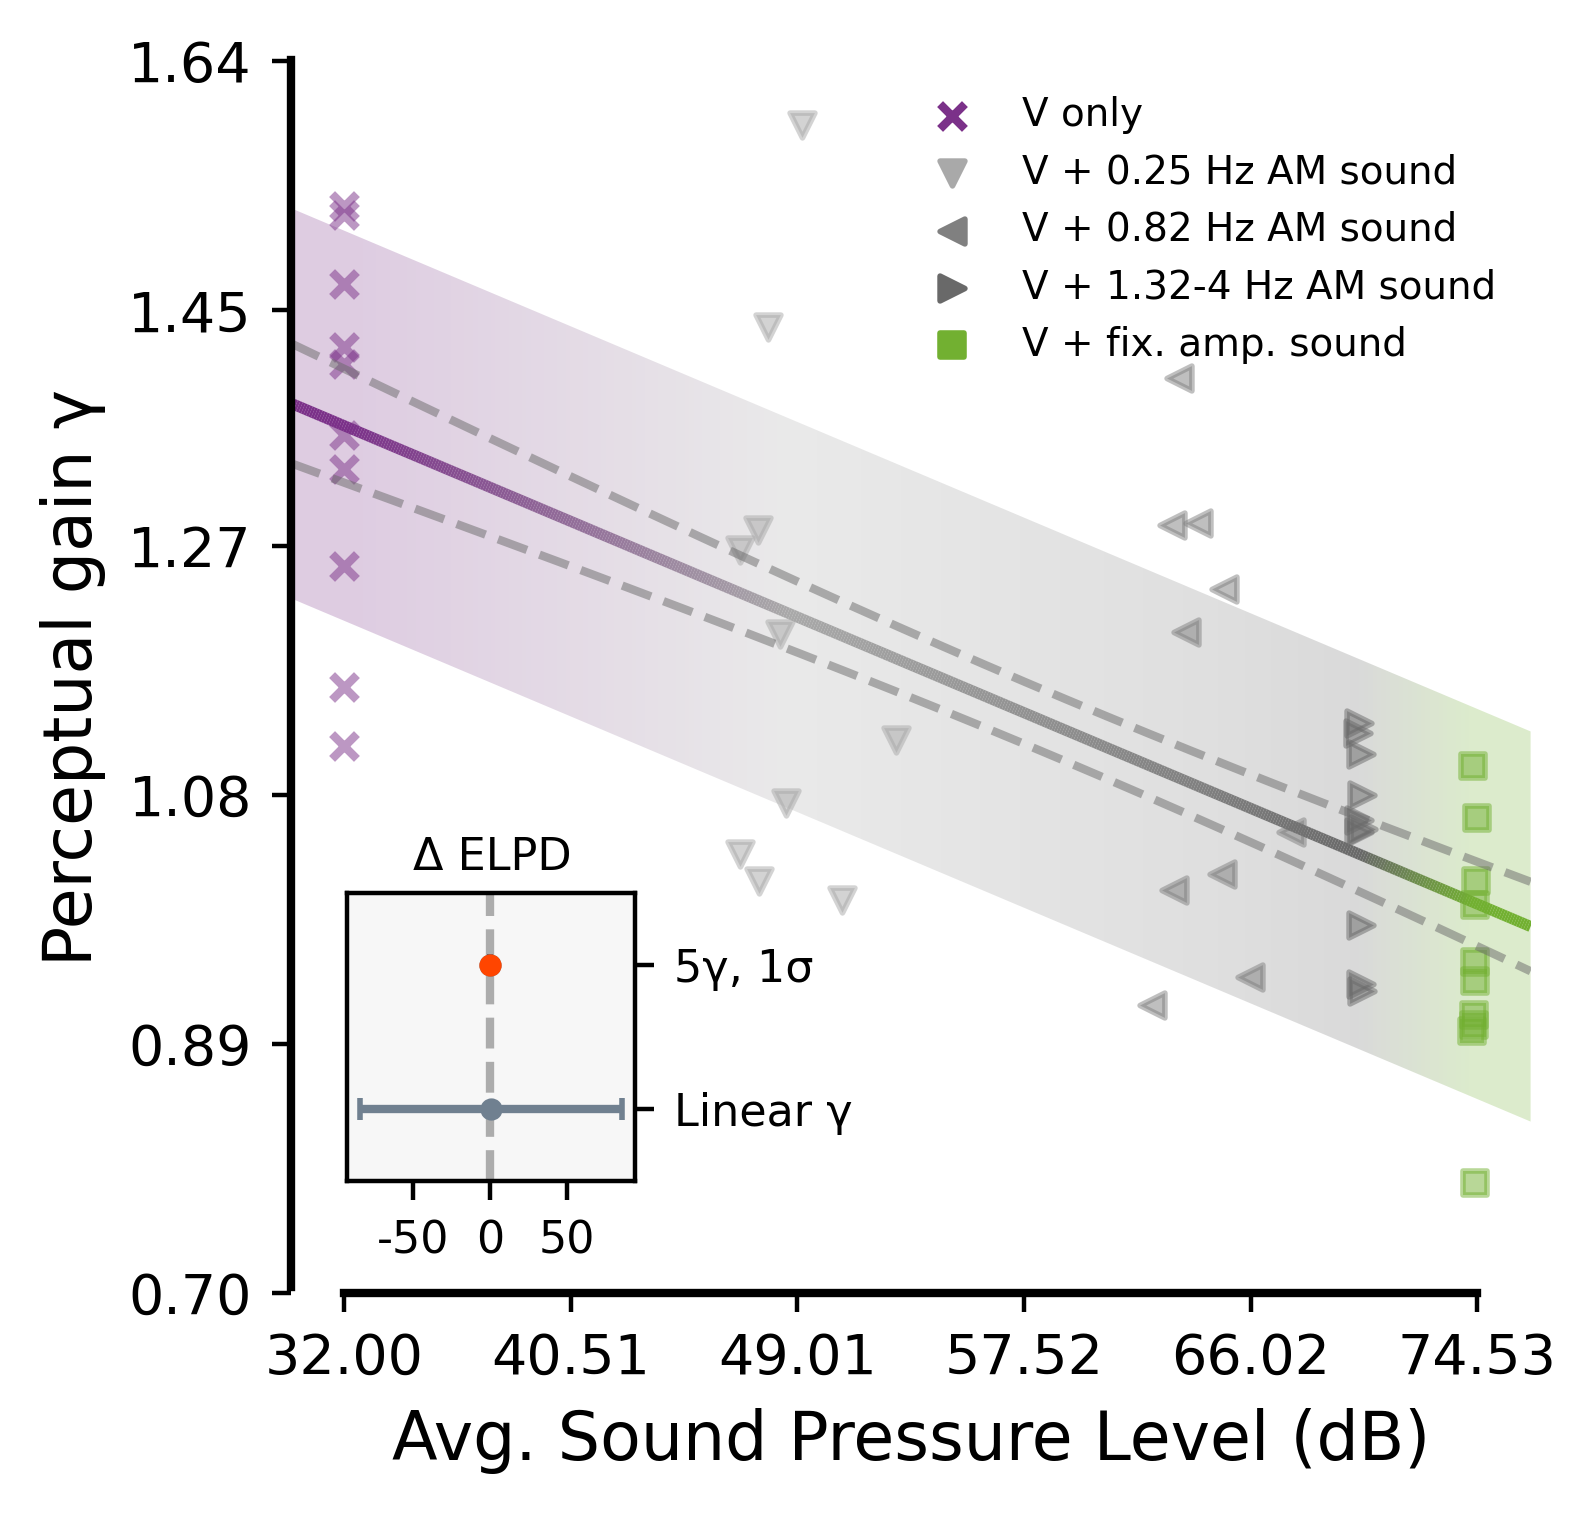

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap, to_rgba

r_in_per_type_mean =  np.mean(rat_intensity_per_type)
r_in_per_type_std =  np.std(rat_intensity_per_type)
r_in_per_type_standard =  (rat_intensity_per_type - r_in_per_type_mean) / r_in_per_type_std

line_edge = 2

standard_range = np.linspace(r_in_per_type_standard.min()-line_edge/r_in_per_type_std, r_in_per_type_standard.max()+line_edge/r_in_per_type_std, 500)
original_range = np.linspace(rat_intensity_per_type.min()-line_edge, rat_intensity_per_type.max()+line_edge, 500)

alpha5 = idata["Linear"].posterior["α_γ_μ_standard"].stack(sample=("chain", "draw")).values
beta5 = idata["Linear"].posterior["β_γ_μ_standard"].stack(sample=("chain", "draw")).values
gamma_sigma = idata["Linear"].posterior["γ_σ"].stack(sample=("chain", "draw")).values
rat_gammas = idata["Linear"].posterior["γ"].mean(("chain","draw"))

posterior_gamma_lines = alpha5[:, np.newaxis] + beta5[:, np.newaxis] * standard_range[np.newaxis, :]
mean_gamma_lines = posterior_gamma_lines.mean(axis=(0))
sigma_gamma_lines = posterior_gamma_lines.std(axis=(0))

mean_plus_sigma = (posterior_gamma_lines + gamma_sigma[:,None]).mean(axis=0) 
mean_minus_sigma = (posterior_gamma_lines - gamma_sigma[:,None]).mean(axis=0)

mean_intensity_per_type = np.mean(rat_intensity_per_type, axis=1)
std_intensity_per_type = np.std(rat_intensity_per_type, axis=1)

# GRADIENT SETUP
gradient_colors = ['#7b3189', 'darkgray', 'gray', 'dimgray', '#72b031']
gradient_x_points = np.array([32.        , 48.62511735, 64.29371093, 70.1371399 , 74.4238453 ])

def build_custom_cmap(colors, points):
    norm_points = (points - points.min()) / (points.max() - points.min())
    cdict = {'red': [], 'green': [], 'blue': []}
    for point, color in zip(norm_points, colors):
        r, g, b, a = to_rgba(color)
        cdict['red'].append((point, r, r))
        cdict['green'].append((point, g, g))
        cdict['blue'].append((point, b, b))
    return LinearSegmentedColormap('custom_cmap', cdict)

custom_cmap = build_custom_cmap(gradient_colors, gradient_x_points)
norm = plt.Normalize(vmin=gradient_x_points.min(), vmax=gradient_x_points.max())


fig, ax = plt.subplots(figsize=(4,4), dpi=400)

# GRADIENT PLOT
y_fill_lower = mean_minus_sigma
y_fill_upper = mean_plus_sigma

polygon = ax.fill_between(original_range, y_fill_lower, y_fill_upper, color='none')
gradient_image = np.vstack((original_range, original_range))
im = ax.imshow(
    gradient_image,
    interpolation='bicubic',
    cmap=custom_cmap,
    norm=norm,
    extent=(original_range.min(), original_range.max(), y_fill_lower.min(), y_fill_upper.max()),
    aspect='auto',
    alpha=0.25
)
im.set_clip_path(polygon.get_paths()[0], transform=ax.transData)
ax.plot(original_range, mean_gamma_lines - 1 * sigma_gamma_lines, linestyle="dashed", alpha=0.5, color = "dimgray")
ax.plot(original_range, mean_gamma_lines + 1 * sigma_gamma_lines, linestyle="dashed", alpha=0.5, color = "dimgray")


points = np.array([original_range, mean_gamma_lines]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments, cmap=custom_cmap, norm=norm)
lc.set_array(original_range)
lc.set_linewidth(2) 
ax.add_collection(lc)

for i in range(5):
    ax.scatter(rat_intensity_per_type[i],rat_gammas[i], marker=markers[i], alpha=0.5, c=colormap[i], s=20, label=legends[i])

ax.set_ylabel("Perceptual gain γ", fontsize=12)
ax.set_xlabel("Avg. Sound Pressure Level (dB)", fontsize=12)

ax.set_yticks(np.linspace(np.min(rat_gammas)-0.08, np.max(rat_gammas)+0.05,6).round(2))
ax.set_xticks(np.linspace(np.min(rat_intensity_per_type), np.max(rat_intensity_per_type+0.005),6).round(2))

ax.set_xlim((np.min(rat_intensity_per_type)-2, np.max(rat_intensity_per_type+0.005)+2))


ax.spines.bottom.set_bounds(np.min(rat_intensity_per_type)+ 0.0005,np.max(rat_intensity_per_type+0.005).round(2)-0.0005)
ax.spines.left.set_bounds(np.min(rat_gammas)-0.08,np.max(rat_gammas)+0.05-0.0005)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines['left'].set_linewidth(1.5)   
ax.spines['bottom'].set_linewidth(1.5)

leg = plt.legend(fontsize=7, frameon=False, loc="upper right")
for lh in leg.legend_handles: #leg.legend_handles
    lh.set_alpha(1)

# INSERT
left, bottom, width, height = [0.16, 0.18, 0.18, 0.18]
ax1 = fig.add_axes([left, bottom, width, height],facecolor=".97")

ax1.set_ylim(-0.5,1.5)
ax1.yaxis.tick_right()

ax1.errorbar(comparison_linear_diff,comp_names, xerr = comparison_linear_dse, fmt = '.', capsize = 2, color="slategray")
ax1.axvline(comparison_linear_diff[-1], linestyle = 'dashed', color = 'k', alpha=0.3)
ax1.scatter(comparison_linear_diff[-1],comp_names[-1], color="orangered", marker=".", zorder=10)

ax1.set_yticks([0,1], comp_names, rotation = -0, fontsize = 8)
ax1.set_xticks([-50,0,50], [-50,0,50], fontsize = 8)

ax1.text(-50, 1.75, r'Δ ELPD', va='center', rotation='horizontal', fontsize = 8)

plt.savefig("extended_7_Linear_Model.png", format = "png", bbox_inches='tight')
plt.show()

#### Average Intensity per Noise Frequency

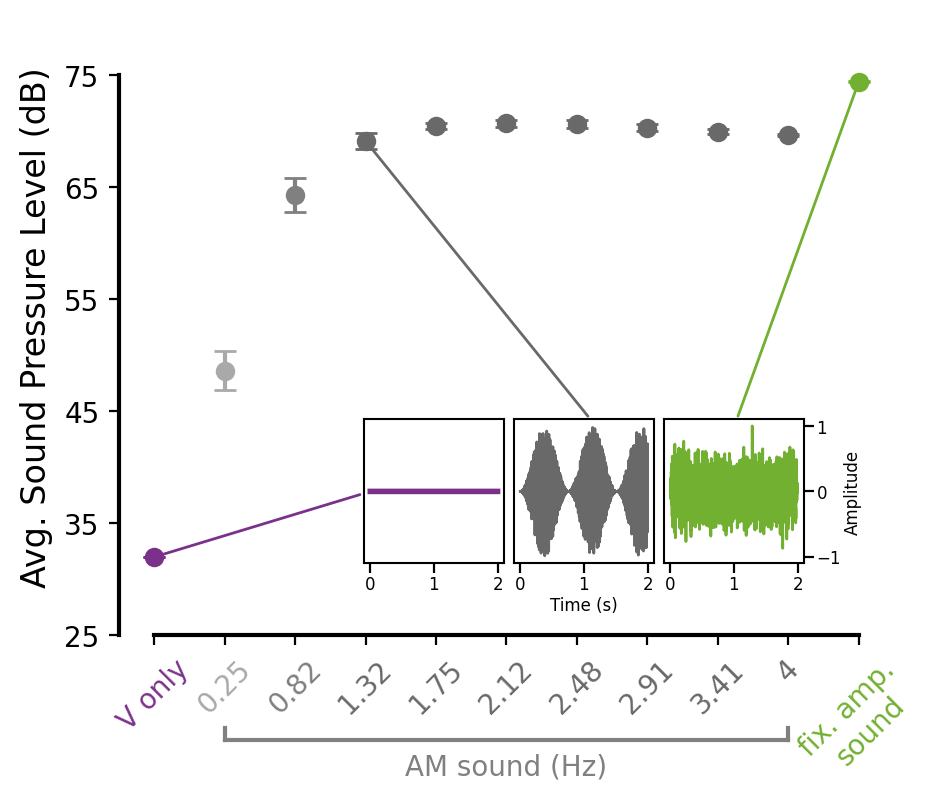

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import ConnectionPatch

mean_intensity_per_freq = np.mean(rat_dBintensity_per_freq, axis=0)
std_intensity_per_freq = np.std(rat_dBintensity_per_freq, axis=0)

# Define x-axis positions and labels
x_positions = np.arange(1, 12)
x_labels = [
    'V only', '0.25', '0.82', '1.32', '1.75',
    '2.12', '2.48', '2.91', '3.41', '4', 'fix. amp.\nsound'
]

# --- 2. Main Plot Creation ---
fig, ax = plt.subplots(figsize=(5, 4), dpi=200)

for i in range(len(x_positions)):
    ax.errorbar(
        x=x_positions[i], y=mean_intensity_per_freq[i],
        yerr=std_intensity_per_freq[i], fmt='o', color=colormap_extended[i],
        ecolor=colormap_extended[i], capsize=4, markersize=6, zorder=5
    )


# --- 3. Axis Formatting and Labeling ---
ax.set_ylabel("Avg. Sound Pressure Level (dB)", fontsize=12)
y_min, y_max_main = 25, 80
x_min, x_max = 1, 11

ax.set_xlim(x_min - 0.5, x_max + 0.5)
ax.set_ylim(y_min, y_max_main)

ax.set_yticks(np.linspace(y_min, 75, 6).round(2))
ax.set_xticks(x_positions)
ax.set_xticklabels(x_labels, rotation=45)
for tick_label, color in zip(ax.get_xticklabels(), colormap_extended):
    tick_label.set_color(color)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_bounds(y_min, 75)
ax.spines['bottom'].set_bounds(x_min, x_max)

# --- 4. X-axis Bracket and Label ---
bracket_y_pos, text_y_pos = -0.17, -0.19
bracket_start_x, bracket_end_x = x_positions[1], x_positions[9]

ax.plot([bracket_start_x, bracket_end_x], [bracket_y_pos, bracket_y_pos], c='gray', transform=ax.get_xaxis_transform(), clip_on=False)
ax.plot([bracket_start_x, bracket_start_x], [bracket_y_pos + 0.02, bracket_y_pos], c='gray', transform=ax.get_xaxis_transform(), clip_on=False)
ax.plot([bracket_end_x, bracket_end_x], [bracket_y_pos + 0.02, bracket_y_pos], c='gray', transform=ax.get_xaxis_transform(), clip_on=False)
ax.text((bracket_start_x + bracket_end_x) / 2, text_y_pos, 'AM sound (Hz)', ha='center', va='top', c='gray', fontsize=10, transform=ax.get_xaxis_transform())

# --- 5. Add Inset Plots with Full Axes and Labels ---

# Define positions [left, bottom, width, height] for the insets in figure coordinates
# Increased the size to make room for labels
inset_width = 0.14
inset_height = 0.18
inset_start_x = 0.37
inset_start_y = 0.2
inset_space = 0.01
inset_positions = [
    [inset_start_x, inset_start_y, inset_width, inset_height],  # Inset 1 (V only)
    [inset_start_x + inset_width + inset_space, inset_start_y, inset_width, inset_height],  # Inset 2 (Middle AM sound)
    [inset_start_x + 2*(inset_width + inset_space), inset_start_y, inset_width, inset_height],  # Inset 3 (Fixed amp.)
]

# Indices of the data points in the main plot to connect to
point_indices = [0, 3, -1] # First, 6th, and last points

# Titles for each inset, derived from the x-labels
inset_titles = [x_labels[i].replace('\n', ' ') for i in point_indices]


T = 2
camp_freq = 882
times_plot = np.linspace(0,T,int(T*camp_freq))

for i, (pos, point_idx, title) in enumerate(zip(inset_positions, point_indices, inset_titles)):
    # Create the inset axes
    ax_inset = fig.add_axes(pos)

    linew = 2 if point_idx == 0 else 1
    ax_inset.plot(times_plot, sequences[point_idx][36::50], color=colormap_extended[point_idx], lw=linew)

    # --- Customize the inset plot ---
    if point_idx == point_indices[1]:
        ax_inset.set_xlabel("Time (s)", fontsize=6, labelpad=1)
    
    # Make axis spines thinner
    for spine in ax_inset.spines.values():
        spine.set_linewidth(0.75)
        
    # Set y-limits and customize tick labels
    ax_inset.set_ylim(-1.1, 1.1)
    ax_inset.tick_params(axis='both', which='major', labelsize=6, pad=1)

    if point_idx == point_indices[-1]:
        ax_inset.set_yticks([-1,0,1])
        ax_inset.yaxis.tick_right()
        ax_inset.set_ylabel("Amplitude", fontsize=6, labelpad=1)
        ax_inset.yaxis.set_label_position("right")
    else:
        ax_inset.set_yticks([])
    ax_inset.set_xticks([0,1,2])

    # --- Draw Connecting Line ---
    # Start point: The data point in the main plot
    xy_start = (x_positions[point_idx], mean_intensity_per_freq[point_idx])
    # End point: The bottom left corner of the inset axes
    offset = 0.004
    xy_end = (pos[0]-offset, pos[1]+inset_height/2-offset) if point_idx == 0 else (pos[0]+inset_width/2+offset, pos[1]+inset_height+offset)

    con = ConnectionPatch(
        xyA=xy_start, xyB=xy_end,
        coordsA=ax.transData, coordsB=fig.transFigure,
        color=colormap_extended[point_idx], linestyle='-',
        linewidth=1, zorder=0
    )
    fig.patches.append(con)

plt.savefig("Sound_Pressure_per_Noise.svg", format="svg")
plt.show()

#### Intensity computation plot

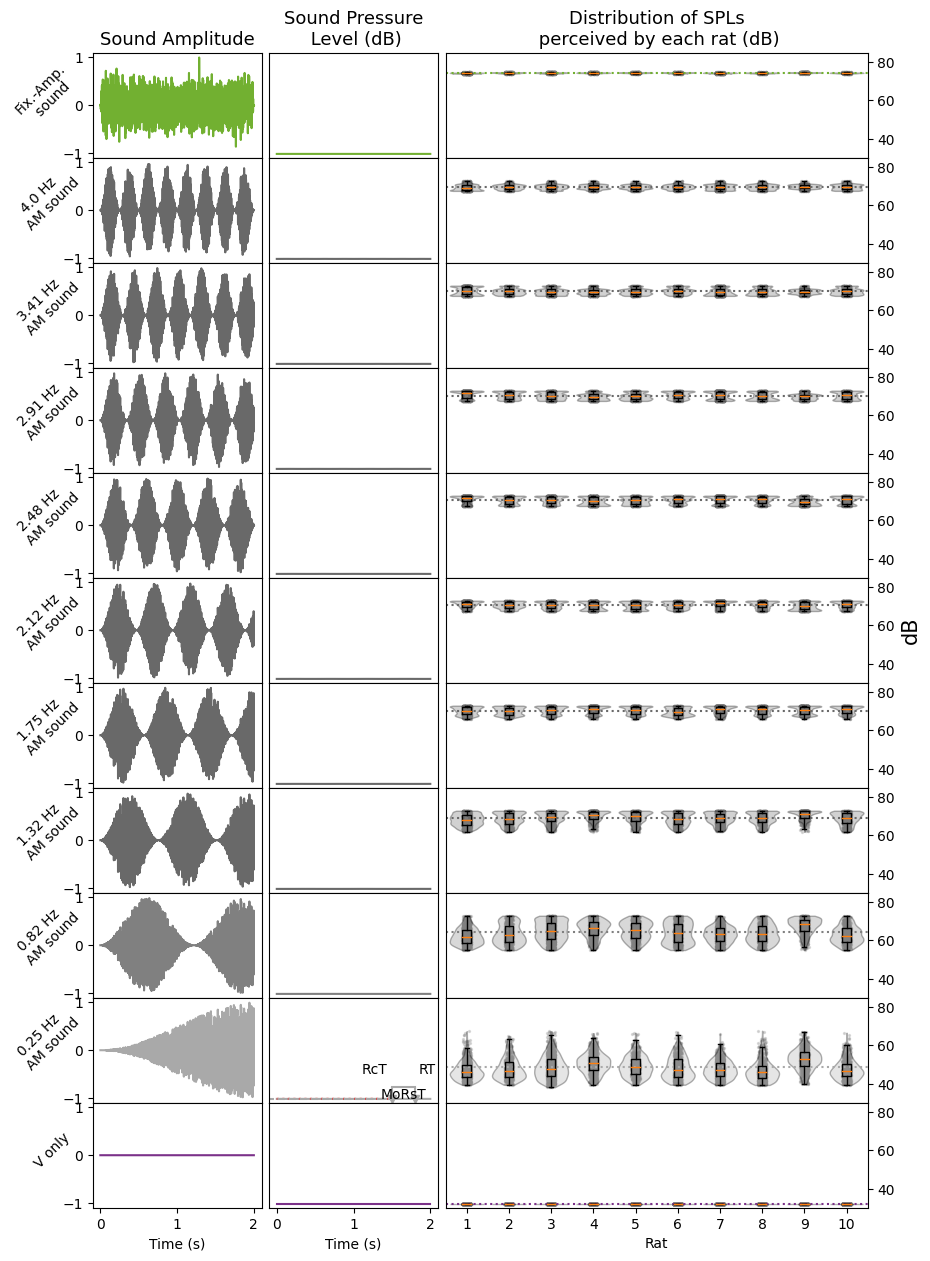

In [52]:
T = 2
camp_freq = 882

times_plot = np.linspace(0,T,int(T*camp_freq))
times = np.linspace(0,T,100)

fig, axs = plt.subplots(nrows=11, ncols=3, sharex=False, figsize=(10,15), dpi=100,
                        gridspec_kw={'hspace': 0, 'wspace': 0.03, 'width_ratios': [1,1,2.5]})  # Remove vertical space and add some horizontal space
                        # gridspec_kw={'width_ratios': [1,1,1,2]} )

for ax in axs[:, 0]:  # Second column subplots
  # Move y-axis label to the right
    ax.set_ylim([-1.1,1.1])
    ax.set_xlim([-0.1,2.1])

# Iterate over all subplots to adjust tick parameters
limits_y = [30,85]
for ax in axs[:, 1]:  # Second column subplots
    ax.yaxis.tick_right()  # Move y-axis ticks to the right
    ax.set_yticks([])
    ax.yaxis.set_label_position("right")  # Move y-axis label to the right
    ax.set_ylim(limits_y)
    ax.set_xlim([-0.1,2.1])

# Iterate over all subplots to adjust tick parameters
for ax in axs[:, 2]:  # Second column subplots
    ax.yaxis.tick_right()  # Move y-axis ticks to the right
    ax.yaxis.set_label_position("right")  # Move y-axis label to the right
    ax.set_ylim(limits_y)
    ax.set_xticks(data["Rat"].unique())
    ax.set_xlim([0.5,10.5])


for i in np.arange(0,11):
    v = data["Noise_Frequency"].unique()[i]
    ω = 2*np.pi*v
    noise = np.random.random(int(T*camp_freq))*2-1
    signal = noise
    if i>0 and i<10:
        modulation = (-np.cos(ω * np.arange(int(T*camp_freq))/camp_freq)+1)/2
        signal = modulation*noise
    if i==0: signal = np.zeros(int(T*camp_freq))
    vv = str(v) + " Hz \n AM sound"
    if v==1e-5: vv = "V only"
    if v>10: vv = "Fix.-Amp.\n sound"
    axs[10-i,0].set_ylabel(f'{vv}', rotation = 45)
    axs[10-i,0].plot(times_plot,sequences[i][36::50], color = colormap[min(i,3) if i<10 else 4])
    axs[10-i,1].plot(times,decibel_intensity(sequences[i],220)[::4], color = colormap[min(i,3) if i<10 else 4])

    
    all_intensities_of_freq =  [all_intensities[r-1][i] for r in data["Rat"].unique()]
    # Plot the jittered points
    for j, d in enumerate(all_intensities_of_freq):
        axs[10-i,2].scatter(np.full(len(d), j+1) + np.random.random(len(d))*0.2-0.1, d, s=2, color = "Gray", alpha = 0.25)
    axs[10-i,2].axhline(np.mean(rat_dBintensity_per_freq[:,i]), linestyle=":",color = colormap[min(i,3) if i<10 else 4])
    # Create boxplots
    boxplot_positions = data["Rat"].unique()
    axs[10-i,2].boxplot(all_intensities_of_freq, positions=boxplot_positions, widths=0.2, showfliers=False)#, boxprops=dict(color='red', linewidth=1.5))
    
    # Set labels and title
    axs[10-i,2].set_xticks(boxplot_positions)
    axs[10-i,2].set_xticklabels(data["Rat"].unique())
    
    # Add violin plots
    violinplot_positions = boxplot_positions
    violin_parts = axs[10-i,2].violinplot(all_intensities_of_freq, positions=violinplot_positions, widths=0.8, showmeans=False, showextrema=False )
    
    for pc in violin_parts['bodies']:
        pc.set_facecolor(colormap[min(i,3) if i<10 else 4])
        pc.set_edgecolor('black')

decpow = decibel_intensity(1/2 * (1 - np.cos(2 * np.pi * data["Noise_Frequency"].unique()[1] * times)) * np.sqrt(1/3), 1)
times_RcT = np.array([1.5,1.8])
index_RcT = np.array(times_RcT/2*100).astype(int)
axs[9,1].stem(times_RcT,[decpow[index_RcT[0]], decpow[index_RcT[1]]],markerfmt="v", linefmt="Darkgray",basefmt="Darkgray", bottom=limits_y[0]+8)

axs[9,1].text(times_RcT[0]-0.4, 45, "RcT")
axs[9,1].text(times_RcT[1]+0.05, 45, "RT")
axs[9,1].text(times_RcT.mean()-0.3, limits_y[0] + 2, "MoRsT")
axs[9,1].plot(times[:index_RcT[0]],decpow[:index_RcT[0]], linestyle = ":", color = "red")
axs[9,1].plot([-1,times[index_RcT[0]]],[np.mean(decpow[:index_RcT[0]]),np.mean(decpow[:index_RcT[0]])], linestyle = "dashed", color = colormap[1])

axs[10,0].set_xlabel('Time (s)')
axs[10,1].set_xlabel('Time (s)')
axs[10,2].set_xlabel('Rat')
axs[5,2].set_ylabel('dB', rotation = 90,fontsize=15)

axs[0,0].set_title('Sound Amplitude', fontsize=13)
axs[0,1].set_title('Sound Pressure\n Level (dB)', fontsize=13)
axs[0,2].set_title('Distribution of SPLs\n perceived by each rat (dB)', fontsize=13)

for ax in axs[:, 1]:  # Second column subplots
    ax.yaxis.tick_right()  # Move y-axis ticks to the right
    ax.yaxis.set_label_position("right")  # Move y-axis label to the right

# Lambda model

In [53]:
idata_lambda = {k: idata[k] for k in set(["5γ_1σ","5γ_1σ_λ"])}
comparison_lambda = az.compare(idata_lambda, ic="loo")
comparison_lambda

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
5γ_1σ,0,-34395.745924,77.358851,0.000000,1.0,156.527493,0.000000,False,log
5γ_1σ_λ,1,-34396.486046,78.551017,0.740123,0.0,156.537876,0.940641,False,log


In [54]:
az.summary(idata["5γ_1σ_λ"], var_names = ["λ_μ"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
λ_μ,-0.166,0.187,-0.499,0.194,0.003,0.002,4102.0,2682.0,1.0


In [55]:
az.summary(idata["5γ_1σ_λ"], var_names = ["λ"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
λ[0],-0.203,0.222,-0.582,0.260,0.004,0.003,3580.0,2789.0,1.0
λ[1],-0.142,0.205,-0.484,0.265,0.003,0.003,4173.0,2664.0,1.0
λ[2],-0.178,0.198,-0.561,0.187,0.003,0.002,4154.0,2748.0,1.0
λ[3],-0.180,0.211,-0.575,0.219,0.003,0.003,4058.0,2826.0,1.0
λ[4],-0.142,0.200,-0.491,0.252,0.003,0.002,3823.0,3103.0,1.0
λ[5],-0.118,0.208,-0.484,0.271,0.003,0.003,4141.0,3277.0,1.0
λ[6],-0.183,0.222,-0.563,0.249,0.004,0.003,4144.0,2912.0,1.0
λ[7],-0.161,0.200,-0.504,0.232,0.003,0.002,4173.0,2953.0,1.0
λ[8],-0.189,0.214,-0.551,0.247,0.003,0.003,3924.0,2900.0,1.0
λ[9],-0.161,0.197,-0.517,0.215,0.003,0.002,4187.0,3161.0,1.0


In [56]:
lambda_mu_values = np.array(idata["5γ_1σ_λ"].posterior.λ_μ.stack(draws=("chain", "draw")))
p_of_direction = len(lambda_mu_values[lambda_mu_values<0])/len(lambda_mu_values)
p_of_direction

0.82125

# Watermark

In [30]:
%load_ext watermark
%watermark
%watermark -iv

Last updated: 2025-02-25T16:38:40.236199+01:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.0-130-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

pymc      : 5.2.0
pytensor  : 2.10.1
scipy     : 1.10.1
arviz     : 0.15.1
numpy     : 1.23.5
pandas    : 1.5.3
matplotlib: 3.7.1
numba     : 0.56.4
xarray    : 2023.3.0

